# Analyse, Clusters et ACP

Nous allons maintenant créer des clusters parmis les pays. 

Nous procéderons d'abord à une classification ascendante hiérarchique, puis nous formerons des clusters à l'aide de la méthode du Kmeans et nous ferons une ACP afin de visualiser les pays sur 2 et 3 dimensions.

Nous utiliserons les données avec l'imputation par KNN.

Pour la première itération, je garde les 4 outliers et toutes les variables.

Pour la deuxième itération, j'enlèverai les 4 outliers, certaines variables et je modifierai le nombre de clusters.

##  Sommaire <a id='sommaire'></a>
<ol><li><a href="#import">Import fichiers</a></li>
    <li><a href="#class_hierar">Classification hiérarchique</a></li>
    <li><a href="#kmeans">Kmeans</a></li> 
        <ol>
            <li><a href="#coude">Méthode du coude avec standardisation</a></li>
            <li><a href="#metric_clusters">Mesure de qualité des clusters : Silhouette score et Davies Bouldin score</a></li>
            <li><a href="#real_kmeans">Réalisation KMeans</a></li>
        </ol>
    <li><a href="#acp">ACP (ou PCA), Analyse en composantes principales</a></li> 
        <ol>
            <li><a href="#qualite_pca">Evaluation de la qualité de la PCA</a></li>
            <li><a href="#kmo">Tentative d'amélioration du KMO</a></li>
            <li><a href="#pca">Réalisation ACP</a></li>
            <li><a href="#eboulie">Graphique éboulie des valeurs propres</a></li>
            <li><a href="#analyse_composante">Analyse du sens des composantes principales</a></li>
        </ol>
    <li><a href="#resultats">Analyse Résultats</a></li>
        <ol>
            <li><a href="#cercle_cor">Cercle de corrélation et Représentation des individus sur le plan factoriel</a></li>
            <li><a href="#qualite_repr">Qualité de représentation des individus</a></li>
            <li><a href="#repr_centroides">Représentation des centroides de chaque clusters</a></li>
            <li><a href="#repr_3d">Représentation 3D</a></li>
            <li><a href="#carte">Visualisation des clusters sur la carte</a></li>    
            <li><a href="#pays_clusters">Analyse des pays par clusters</a></li>
            <li><a href="#prop">Proposition de pays</a></li>
        </ol>
    <li><a href="#conclusion">Conclusion première itération</a></li> 
</ol>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [3]:
from factor_analyzer import calculate_kmo
from factor_analyzer import calculate_bartlett_sphericity

In [4]:
import plotly.express as px

In [5]:
folder = 'D:/Data_Analyst_Projet/Projet 9/Donnees/fichier analyse/'

In [6]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_row', 150)

In [7]:
warnings.simplefilter('ignore')

<a id="import" ></a>
## Import fichiers<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [8]:
df = pd.read_csv(folder+'pays_knn.csv')
df.head()

pays  exportation_volaille  importation_volaille   production  \
0  Afrique du Sud             63,000.00            514,000.00 1,667,000.00   
1         Albanie                  0.00             38,000.00    13,000.00   
2         Algérie                  0.00              2,000.00   275,000.00   
3       Allemagne            646,000.00            842,000.00 1,514,000.00   
4          Angola                  0.00            277,000.00    42,000.00   

   volaille_consommée  taux_dependance  taux_autosuffisance  \
0        2,035,000.00             0.24                 0.76   
1           47,000.00             0.81                 0.28   
2          264,000.00             0.01                 0.99   
3        1,609,000.00             0.48                 0.50   
4          315,000.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  \
0                            0.06                           0.12   
1                            0.01                           0.05   
2                            0.01                           0.03   
3                            0.02                           0.10   
4                            0.02                           0.07   

     population  ...  taux_accroissement_population_moyen  lpi  \
0 57,009,756.00  ...                                 0.01 3.57   
1  2,884,169.00  ...                                -0.00 2.56   
2 41,389,189.00  ...                                 0.01 2.52   
3 82,658,409.00  ...                                 0.00 4.13   
4 29,816,766.00  ...                                 0.03 2.24   

                   pib  taux_droit_douane  quantite_conteneurs_par_annee  \
0   381,448,814,653.46               4.44                   4,563,618.00   
1    13,019,689,336.69               1.43                     118,270.00   
2   170,097,014,589.13               9.28                   1,725,238.00   
3 3,690,849,152,517.65               1.81                  15,169,595.00   
4    68,972,769,395.63               8.52                     570,200.00   

   cout_production_volaille  taux_population_urbaine  stabilite_politique  \
0                  2,016.60                     0.66                -0.28   
1                  2,072.14                     0.60                 0.38   
2                  2,180.70                     0.72                -0.92   
3                  1,459.50                     0.77                 0.59   
4                  2,176.24                     0.65                -0.33   

   pib_par_habitant  classement_consommation  
0          6,690.94                    10.00  
1          4,514.19                   101.50  
2          4,109.70                    51.50  
3         44,651.83                    15.00  
4          2,313.22                    48.50  

[5 rows x 21 columns]

In [9]:
df.shape

(132, 21)

In [10]:
# on garde uniquement les données numériques pour l'analyse 
X = df.drop(columns='pays')

In [11]:
# pays dans une variable array
pays = df['pays'].values

In [12]:
# indicateur dans une variable array
variables = X.columns.values

<a id="class_hierar" ></a>
## Classification ascendante hiérarchique<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

Les différences entre les individus peut se calculer avec la distance euclidienne :
la racine de la somme des différences au carré.

Lors d'une classification hiérarchique, au départ il y a autant de clusters que d'individus.

Ensuite, on regroupe 2 à 2 les individus qui ont la plus petite distance euclidienne, jusqu'à qu'il y est un seul cluster.

In [13]:
# Centrage et réduction pour s'assurer que chaque variable à le même poids sur la classification
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

La méthode de classification hiérarchique s'effectue avec peu de données (50 ou moins).

Nous allons donc prendre un échantillon aléatoire et effectuer le mélange plusieurs fois.

In [14]:
# df standardisé
df_X_scaled = pd.DataFrame(X_scaled, columns=variables, index=pays)
df_X_scaled.head()

exportation_volaille  importation_volaille  production  \
Afrique du Sud                 -0.14                  1.97        0.27   
Albanie                        -0.26                 -0.35       -0.32   
Algérie                        -0.26                 -0.52       -0.23   
Allemagne                       0.99                  3.57        0.22   
Angola                         -0.26                  0.82       -0.31   

                volaille_consommée  taux_dependance  taux_autosuffisance  \
Afrique du Sud                0.51            -0.34                 0.21   
Albanie                      -0.33             0.80                -0.76   
Algérie                      -0.23            -0.82                 0.69   
Allemagne                     0.33             0.15                -0.31   
Angola                       -0.21             0.93                -1.05   

                proportion_volaille_nourriture  proportion_animaux_nourriture  \
Afrique du Sud                            1.41                           0.51   
Albanie                                  -0.84                          -1.18   
Algérie                                  -1.06                          -1.54   
Allemagne                                -0.50                           0.09   
Angola                                   -0.60                          -0.66   

                population  accroissement_population_moyen_par_annee  \
Afrique du Sud        0.04                                      0.12   
Albanie              -0.27                                     -0.31   
Algérie              -0.05                                      0.07   
Allemagne             0.19                                     -0.25   
Angola               -0.12                                      0.18   

                taux_accroissement_population_moyen   lpi   pib  \
Afrique du Sud                                 0.24  1.12 -0.10   
Albanie                                       -1.54 -0.83 -0.28   
Algérie                                        0.49 -0.90 -0.20   
Allemagne                                     -0.93  2.20  1.49   
Angola                                         1.71 -1.44 -0.25   

                taux_droit_douane  quantite_conteneurs_par_annee  \
Afrique du Sud              -0.16                          -0.04   
Albanie                     -0.90                          -0.26   
Algérie                      1.03                          -0.18   
Allemagne                   -0.80                           0.48   
Angola                       0.84                          -0.24   

                cout_production_volaille  taux_population_urbaine  \
Afrique du Sud                     -0.27                     0.12   
Albanie                            -0.18                    -0.13   
Algérie                             0.00                     0.42   
Allemagne                          -1.21                     0.66   
Angola                             -0.00                     0.08   

                stabilite_politique  pib_par_habitant  classement_consommation  
Afrique du Sud                -0.32             -0.50                    -1.49  
Albanie                        0.43             -0.60                     0.84  
Algérie                       -1.04             -0.62                    -0.43  
Allemagne                      0.67              1.34                    -1.36  
Angola                        -0.37             -0.71                    -0.51

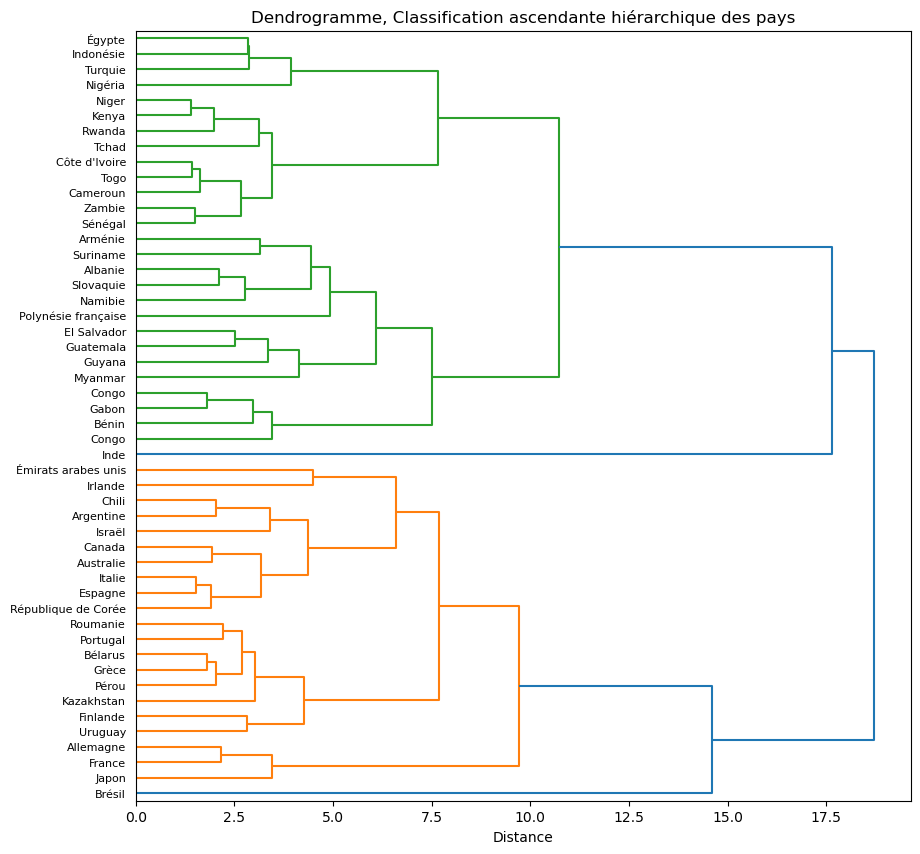

In [15]:
# faire random sample echantillon de 30 pays
# faire plusieurs itération pour valider les clusters
echantillon = df_X_scaled.sample(50)


# mesure les liens entre les clusters avec la méthode de ward
# chaque fois que 2 clusters sont regroupés, cherche à minimiser l'inertie intraclasse

Z = linkage(echantillon, 'ward')


# création du dendogramme
plt.figure(figsize=(10,10))
dendrogram(Z, p=echantillon.shape[0], truncate_mode='lastp', distance_sort='ascending',
           orientation='right', labels=echantillon.index)
plt.title("Dendrogramme, Classification ascendante hiérarchique des pays")
plt.xlabel('Distance')
plt.show();

In [16]:
Z

array([[ 7.        , 23.        ,  1.39484124,  2.        ],
       [15.        , 35.        ,  1.4374598 ,  2.        ],
       [44.        , 46.        ,  1.50827061,  2.        ],
       [ 6.        , 21.        ,  1.52735563,  2.        ],
       [42.        , 51.        ,  1.62748447,  3.        ],
       [ 2.        , 49.        ,  1.79431224,  2.        ],
       [ 3.        , 24.        ,  1.80705343,  2.        ],
       [41.        , 53.        ,  1.90559581,  3.        ],
       [ 5.        , 47.        ,  1.93202221,  2.        ],
       [ 1.        , 50.        ,  1.9889806 ,  3.        ],
       [18.        , 55.        ,  2.03657166,  3.        ],
       [ 0.        , 38.        ,  2.03923637,  2.        ],
       [37.        , 43.        ,  2.09840068,  2.        ],
       [ 8.        , 36.        ,  2.17111678,  2.        ],
       [12.        , 33.        ,  2.20308032,  2.        ],
       [13.        , 27.        ,  2.52376411,  2.        ],
       [52.        , 54.

On distingue 3 clusters graphiquement et les distances euclidiennes entre les clusters sont plus proches à partir de la 4e valeur d'après le Z (3e colonne).

Cependant, il semblerait que les outliers forment un cluster à eux tout seul. Ce qui n'est pas bon dans une classification.  
On continue tout de même jusqu'au bout, on réglera le problème lors de la prochaine itération.

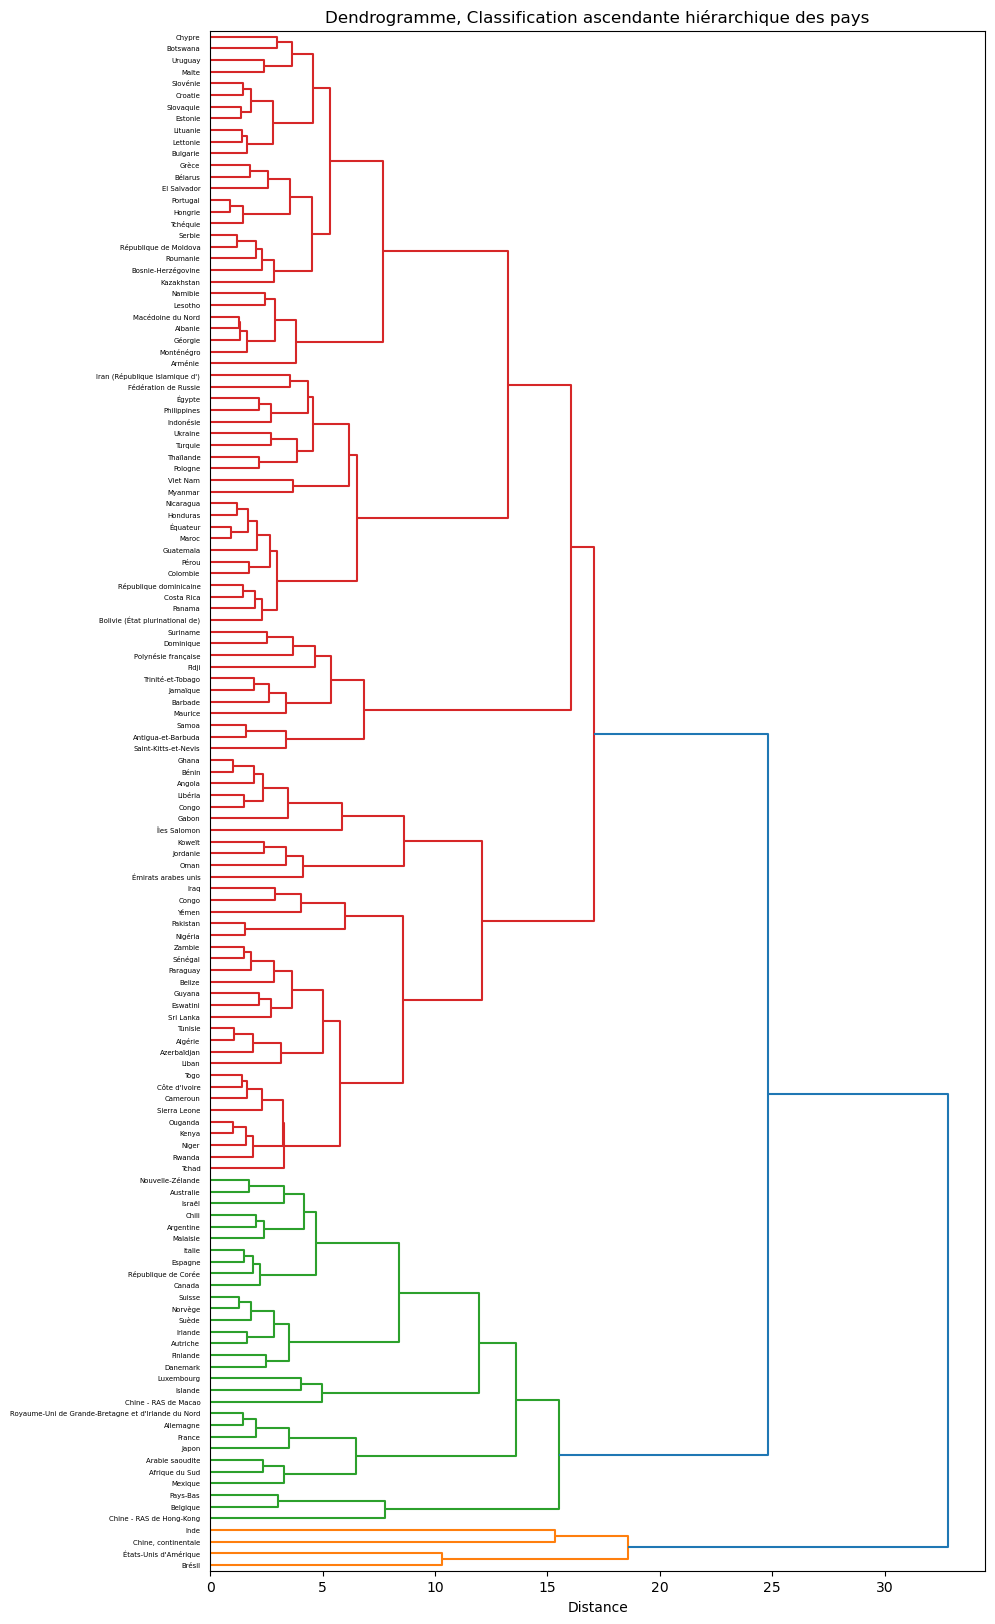

In [17]:
# Dendogramme global

Z = linkage(X_scaled, 'ward')


# création du dendogramme
plt.figure(figsize=(10,20))
dendrogram(Z, p=X_scaled.shape[0], truncate_mode='lastp', distance_sort='ascending',
           orientation='right', labels=pays)
plt.title("Dendrogramme, Classification ascendante hiérarchique des pays")
plt.xlabel('Distance')
plt.show();

In [18]:
Z

array([[ 52.        ,  96.        ,   0.87809186,   2.        ],
       [ 76.        , 129.        ,   0.92273834,   2.        ],
       [ 65.        ,  88.        ,   1.00391116,   2.        ],
       [ 21.        ,  46.        ,   1.03817458,   2.        ],
       [  2.        , 120.        ,   1.07007917,   2.        ],
       [ 51.        ,  82.        ,   1.19602424,   2.        ],
       [102.        , 106.        ,   1.21564004,   2.        ],
       [  1.        ,  73.        ,   1.27386297,   2.        ],
       [ 85.        , 111.        ,   1.29607687,   2.        ],
       [ 50.        , 139.        ,   1.30828569,   3.        ],
       [ 39.        , 108.        ,   1.36957332,   2.        ],
       [ 68.        ,  71.        ,   1.40375667,   2.        ],
       [ 34.        , 118.        ,   1.4374598 ,   2.        ],
       [ 33.        , 109.        ,   1.44974482,   2.        ],
       [ 32.        , 103.        ,   1.45636974,   2.        ],
       [116.        , 132

On distingue bien 3 à 4 clusters avec un des clusters composé des 4 outliers. On divisera l'échantillon en 3 clusters pour cette itération.

In [19]:
# création de la classification
cah = AgglomerativeClustering(n_clusters=3, linkage='ward')

cah = cah.fit(X_scaled)

In [20]:
# création des clusters
clusters_cah = cah.labels_

df['clusters_cah'] = clusters_cah

<a id="kmeans" ></a>
## Kmeans<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

<a id='coude' ></a>
### Méthode du coude avec standardisation<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

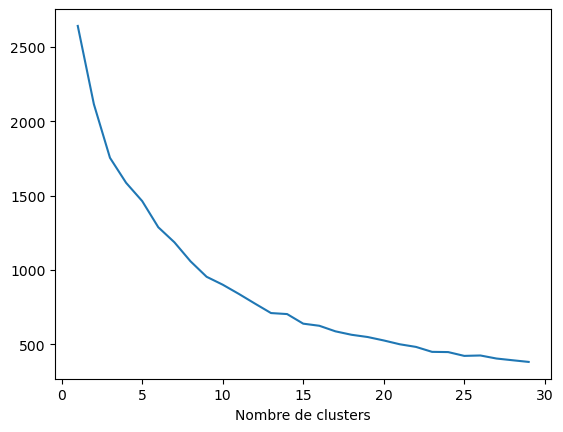

In [21]:
# méthode du coude pour déterminer le nombre de clusters le plus pertinents
# on standardise les données au préalable

liste_clusters = []

for n in range(1,30):
    kmeans = KMeans(n_clusters=n, random_state=1)
    kmeans.fit(X_scaled)
    liste_clusters.append(kmeans.inertia_)

plt.plot(range(1,30), liste_clusters)
plt.xlabel('Nombre de clusters');

Pas vraiment de coude visible, on distingue de légères cassures à 2, 3 et 4 clusters.

<a id='metric_clusters' ></a>
### Mesure de qualité des clusters : Silhouette score et Davies Bouldin score<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

Le **silhouette score** mesure si les individus sont bien regroupés à l'intérieur de leur clusters tout en étant suffisamment séparés des autres clusters. Il varie entre -1 et 1.

- Un score de silhouette proche de 1 indique que l'individu est bien placé dans son propre cluster et qu'il est loin des individus des autres clusters.
- Un score de silhouette proche de 0 indique que l'individu est proche de la frontière entre deux clusters.
- Un score de silhouette proche de -1 indique que l'individu est probablement mal placé et qu'il serait mieux dans un autre cluster.
    
    
Le **Davies-Bouldin score** mesure l'homégénéité du cluster (variance intraclasse) et la séparation entre clusters (variance interclasse). On cherche à avoir une homogénéité faible et une séparation élevé.  
Le **Davies-Bouldin score** doit être minimum pour un bon clustering.

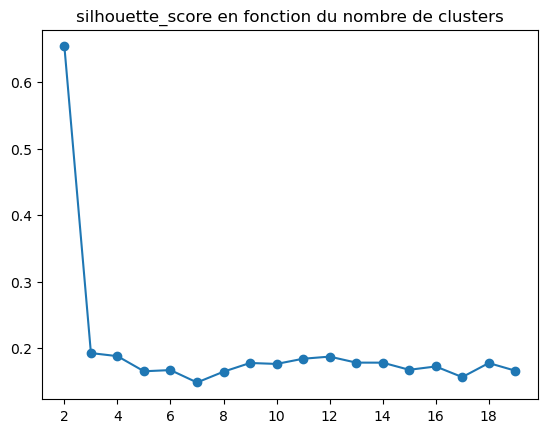

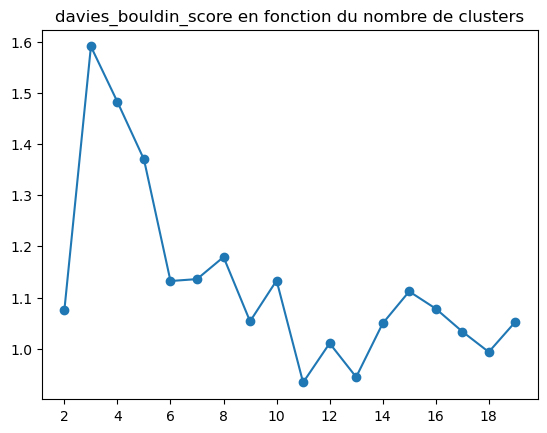

In [22]:
silhouette = []
davies = []

for n_clusters in range(2,20):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_scaled)
    clusters_kmeans = kmeans.labels_
    silhouette.append(silhouette_score(X_scaled, clusters_kmeans))
    davies.append(davies_bouldin_score(X_scaled, clusters_kmeans))
    
plt.plot(range(2,20), silhouette, marker='o')
plt.title('silhouette_score en fonction du nombre de clusters')
plt.xticks(np.arange(2, 20, 2))
plt.show()

plt.plot(range(2,20), davies, marker='o')
plt.title('davies_bouldin_score en fonction du nombre de clusters')
plt.xticks(np.arange(2, 20, 2))
plt.show()

Les 2 scores indiquent 2 clusters comme le meilleurs choix.

Cependant un des clusters est composé seulement des outliers.

Créer seulement 2 clusters va peu partitionner les données et aider à la décision pour l'étude de marché, on choisi 3 clusters pour la première itération.

<a id='real_kmeans' ></a>
### Réalisation KMeans<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [23]:
# création de l'estimateur

kmeans = KMeans(n_clusters=3, random_state=1)

kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=1)

In [24]:
# coordonnées des centroides

centroides = kmeans.cluster_centers_

In [25]:
# clusters de l'echantillon

clusters_kmeans = kmeans.labels_
df['clusters_kmeans']=clusters_kmeans

<a id="acp" ></a>
## ACP (ou PCA), Analyse en composantes principales<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

L'analyse en composantes principales est une technique de réduction de dimensions.  

L'objectif est de trouver 3 variables (les composantes principales) qui résument au mieux l'ensemble de nos variables de départ.
Chaque composantes principales est une combinaison linéaire des variables de départ et idéalement, elles résument chacunes une partie des variables de départ indépendamment.

L'ACP va permettre de visualiser les données dans un espace à 2 ou 3 dimensions, à grouper nos variables et à identifier les similarités et les disparités entre individus en fonction de leur proximité selon les composantes principales.

<a id="qualite_pca" ></a>
### Evaluation de la qualité de la PCA<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

On va mesurer l'utilité et la qualité de l'analyse en composantes principales grâce au KMO.

Le KMO indique si les variables sont assez corrélées pour faire une ACP. Plus le score est élevé, plus l'ACP est pertinente.

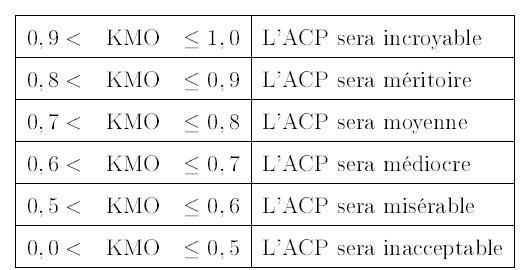

In [26]:
X

exportation_volaille  importation_volaille    production  \
0               63,000.00            514,000.00  1,667,000.00   
1                    0.00             38,000.00     13,000.00   
2                    0.00              2,000.00    275,000.00   
3              646,000.00            842,000.00  1,514,000.00   
4                    0.00            277,000.00     42,000.00   
5                    0.00              7,000.00          0.00   
6               10,000.00            722,000.00    616,000.00   
7              207,000.00              8,000.00  2,161,000.00   
8                    0.00             35,000.00     11,000.00   
9               42,000.00             16,000.00  1,269,000.00   
10              78,000.00            110,000.00    148,000.00   
11                   0.00             27,000.00    104,000.00   
12                   0.00              2,000.00     15,000.00   
13             656,000.00            338,000.00    463,000.00   
14                   0.00                  0.00     20,000.00   
15               1,000.00              1,000.00    533,000.00   
16               8,000.00             10,000.00     61,000.00   
17                   0.00              3,000.00      5,000.00   
18           4,223,000.00              3,000.00 14,201,000.00   
19              45,000.00            108,000.00    107,000.00   
20             152,000.00             21,000.00    463,000.00   
21                   0.00            123,000.00     18,000.00   
22                   0.00                  0.00     81,000.00   
23             163,000.00            182,000.00  1,417,000.00   
24             115,000.00            155,000.00    712,000.00   
25             663,000.00            907,000.00     24,000.00   
26                   0.00             23,000.00      3,000.00   
27             576,000.00            452,000.00 18,236,000.00   
28               1,000.00             14,000.00     25,000.00   
29               2,000.00             78,000.00  1,564,000.00   
30                   0.00            104,000.00      7,000.00   
31                   0.00            104,000.00      7,000.00   
32               3,000.00             17,000.00    133,000.00   
33              17,000.00             24,000.00     61,000.00   
34                   0.00              7,000.00     58,000.00   
35             139,000.00            133,000.00    173,000.00   
36                   0.00              4,000.00          0.00   
37               2,000.00             16,000.00    136,000.00   
38             212,000.00            205,000.00  1,515,000.00   
39              11,000.00             21,000.00     20,000.00   
40                   0.00              2,000.00      6,000.00   
41                   0.00              3,000.00     23,000.00   
42              12,000.00             16,000.00    129,000.00   
43             501,000.00            506,000.00  1,750,000.00   
44             115,000.00            226,000.00  4,444,000.00   
45                   0.00             76,000.00      4,000.00   
46                   0.00            151,000.00     60,000.00   
47              29,000.00             79,000.00    246,000.00   
48               7,000.00            129,000.00    235,000.00   
49                   0.00                  0.00     31,000.00   
50               5,000.00             51,000.00     22,000.00   
51               1,000.00             12,000.00    193,000.00   
52             210,000.00             58,000.00    493,000.00   
53               4,000.00                  0.00  3,545,000.00   
54                   0.00              1,000.00  2,301,000.00   
55              45,000.00              6,000.00  2,174,000.00   
56                   0.00            470,000.00     96,000.00   
57              93,000.00             99,000.00    110,000.00   
58                   0.00              2,000.00     10,000.00   
59               3,000.00                  0.00    629,000.00   
60             183,000.00             97

In [27]:
calculate_kmo(X)

(array([0.46582379, 0.40322725, 0.59637852, 0.63061415, 0.58303553,
        0.55785294, 0.51449942, 0.62289589, 0.565502  , 0.47525753,
        0.37618771, 0.68471193, 0.83990479, 0.80499932, 0.5882999 ,
        0.65032555, 0.76801805, 0.75283337, 0.60521212, 0.73438834]),
 0.6057273718630268)

Dans cette situation, la PCA est indiquée "misérable". 

On va améliorer le KMO en enlevant des variables.

#### Test de sphéricité de Bartlett
Teste l'hypothèse selon laquelle votre matrice de corrélation est une matrice d'identité, ce qui indiquerait que les variables ne sont pas liées et donc ne conviennent pas pour la détection de structure. Des valeurs faibles (inférieures à 0,05) du niveau de signification indiquent qu'une analyse factorielle peut être utile avec vos données.

In [28]:
from factor_analyzer import calculate_bartlett_sphericity

In [29]:
calculate_bartlett_sphericity(X)

(3061.2231926319596, 0.0)

La p-value est inférieur à 0.05, les test est significatif, l'ACP peut être utile aux données.

<a id="kmo" ></a>
### Tentative d'amélioration du KMO<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

Plusieurs possibilités pour améliorer le KMO:
- Analyser le KMO par variable et rejeter les variables qui ont un KMO faible (inférieur ou égale à 0.5)
- Enlever les variables les moins corrélées avec les autres variables 

Les propositions pour améliorer le KMO global proviennent de 2 sources :
- https://spss.espaceweb.usherbrooke.ca/procedure-spss-5/
- Le livre Consis_Statistique consultable ci-dessous à partir de la page 651 chapitre sur l'ACP.

In [30]:
from IPython.display import IFrame
IFrame("Consis_Statistique.pdf", width=600, height=300)

#### KMO par variables

In [31]:
kmo_variable = pd.DataFrame(data=calculate_kmo(X)[0], index=X.columns.values, columns=['KMO'])
kmo_variable.sort_values('KMO', ascending = False)

KMO
pib                                      0.84
taux_droit_douane                        0.80
taux_population_urbaine                  0.77
stabilite_politique                      0.75
classement_consommation                  0.73
lpi                                      0.68
cout_production_volaille                 0.65
volaille_consommée                       0.63
proportion_animaux_nourriture            0.62
pib_par_habitant                         0.61
production                               0.60
quantite_conteneurs_par_annee            0.59
taux_dependance                          0.58
population                               0.57
taux_autosuffisance                      0.56
proportion_volaille_nourriture           0.51
accroissement_population_moyen_par_annee 0.48
exportation_volaille                     0.47
importation_volaille                     0.40
taux_accroissement_population_moyen      0.38

On conserve les variables dont le KMO est supérieur ou égale à 0,5.

##### KMO > 0.5

In [32]:
# score KMO en fonction de la valeur limite KMO variables
for x in np.arange(0.5, 0.6, 0.01):
    kmo_col = kmo_variable[kmo_variable['KMO'] > x].index.values
    print(f'KMO global avec KMO limite = {round(x,2)} :', calculate_kmo(X[kmo_col])[1])

KMO global avec KMO limite = 0.5 : 0.6733781705268643
KMO global avec KMO limite = 0.51 : 0.6733781705268643
KMO global avec KMO limite = 0.52 : 0.6832513651336746
KMO global avec KMO limite = 0.53 : 0.6832513651336746
KMO global avec KMO limite = 0.54 : 0.6832513651336746
KMO global avec KMO limite = 0.55 : 0.6832513651336746
KMO global avec KMO limite = 0.56 : 0.6894878481629272
KMO global avec KMO limite = 0.57 : 0.6551834283720853
KMO global avec KMO limite = 0.58 : 0.6551834283720853
KMO global avec KMO limite = 0.59 : 0.6968743812414327


In [33]:
# on garde les variables dont le kmo est > 0.51, on garde beaucoup de variable et le score est acceptable
kmo_col = kmo_variable[kmo_variable['KMO'] > 0.51].index.values
kmo_col

array(['production', 'volaille_consommée', 'taux_dependance',
       'taux_autosuffisance', 'proportion_volaille_nourriture',
       'proportion_animaux_nourriture', 'population', 'lpi', 'pib',
       'taux_droit_douane', 'quantite_conteneurs_par_annee',
       'cout_production_volaille', 'taux_population_urbaine',
       'stabilite_politique', 'pib_par_habitant',
       'classement_consommation'], dtype=object)

In [34]:
# variables enlevées par la condition ci-dessus
kmo_variable[~(kmo_variable['KMO'] > 0.51)].index.values

array(['exportation_volaille', 'importation_volaille',
       'accroissement_population_moyen_par_annee',
       'taux_accroissement_population_moyen'], dtype=object)

In [35]:
calculate_kmo(X[kmo_col])

(array([0.68524306, 0.66507494, 0.56242832, 0.55920626, 0.48369019,
        0.62072149, 0.86413374, 0.6446307 , 0.9043782 , 0.87045845,
        0.67420079, 0.52246698, 0.72638562, 0.73162047, 0.61342404,
        0.5734028 ]),
 0.6733781705268643)

Le KMO est de 0.71, ce qui est 'moyen' mais acceptable, on va voir si on peut encore l'améliorer.
D'autres sources affirment qu'un KMO est acceptable à partir de 0,6.

In [36]:
X[kmo_col].shape

(132, 16)

##### Variables les moins corrélées aux autres variables

<Axes: >

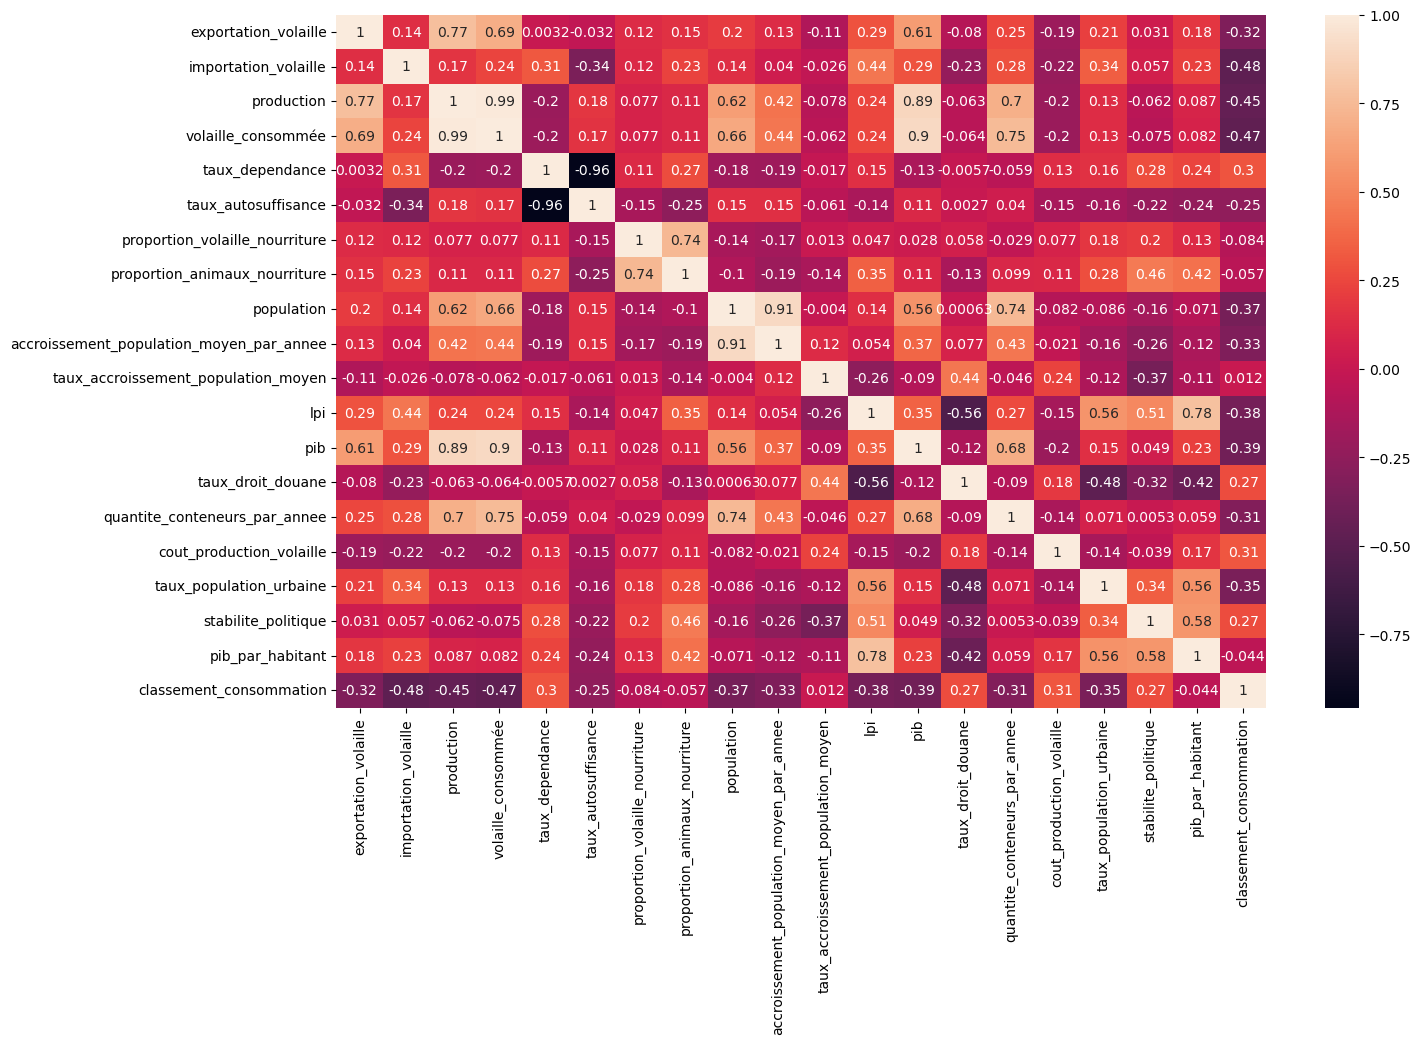

In [37]:
plt.figure(figsize=(15,9))
sns.heatmap(X.corr(), annot=True)

In [38]:
# je détermine les variables corrélées en sommant les valeurs absolues des corrélations des variables 
corr_tot_var = np.abs(X.corr()).sum(axis=1).sort_values(ascending = False)
corr_tot_var

volaille_consommée                         7.55
production                                 7.44
pib                                        7.27
lpi                                        6.91
classement_consommation                    6.44
population                                 6.32
quantite_conteneurs_par_annee              6.06
pib_par_habitant                           5.74
taux_population_urbaine                    5.61
accroissement_population_moyen_par_annee   5.58
exportation_volaille                       5.52
importation_volaille                       5.33
proportion_animaux_nourriture              5.31
stabilite_politique                        5.27
taux_dependance                            4.90
taux_autosuffisance                        4.74
taux_droit_douane                          4.59
cout_production_volaille                   3.94
proportion_volaille_nourriture             3.54
taux_accroissement_population_moyen        3.31
dtype: float64

In [39]:
# on boucle pour déterminer identifier les différents KMO
for x in np.arange(3.5, 6.5, 0.1):
    col_corr = corr_tot_var[corr_tot_var >= x].index.values
    print(f'KMO global avec corrélation limite = {round(x,2)} :', calculate_kmo(X[col_corr])[1])

KMO global avec corrélation limite = 3.5 : 0.6176874925289976
KMO global avec corrélation limite = 3.6 : 0.6203022630353827
KMO global avec corrélation limite = 3.7 : 0.6203022630353827
KMO global avec corrélation limite = 3.8 : 0.6203022630353827
KMO global avec corrélation limite = 3.9 : 0.6203022630353827
KMO global avec corrélation limite = 4.0 : 0.6180356693813893
KMO global avec corrélation limite = 4.1 : 0.6180356693813893
KMO global avec corrélation limite = 4.2 : 0.6180356693813893
KMO global avec corrélation limite = 4.3 : 0.6180356693813893
KMO global avec corrélation limite = 4.4 : 0.6180356693813893
KMO global avec corrélation limite = 4.5 : 0.6180356693813893
KMO global avec corrélation limite = 4.6 : 0.6077433628720006
KMO global avec corrélation limite = 4.7 : 0.6077433628720006
KMO global avec corrélation limite = 4.8 : 0.6035548376816406
KMO global avec corrélation limite = 4.9 : 0.590436489709884
KMO global avec corrélation limite = 5.0 : 0.590436489709884
KMO global

In [40]:
col_corr = corr_tot_var[corr_tot_var >= 4.9].index.values
col_corr

array(['volaille_consommée', 'production', 'pib', 'lpi',
       'classement_consommation', 'population',
       'quantite_conteneurs_par_annee', 'pib_par_habitant',
       'taux_population_urbaine',
       'accroissement_population_moyen_par_annee', 'exportation_volaille',
       'importation_volaille', 'proportion_animaux_nourriture',
       'stabilite_politique'], dtype=object)

In [41]:
len(col_corr)

14

In [42]:
calculate_kmo(X[col_corr])

(array([0.61823079, 0.57932643, 0.83636669, 0.64482361, 0.62450464,
        0.58571374, 0.63413894, 0.61492678, 0.77732103, 0.49889746,
        0.44235256, 0.2999876 , 0.62529043, 0.57362713]),
 0.590436489709884)

La première solution donne de meilleurs résultats en conservant plus de variables.

#### Deuxième KMeans

On refait le KMeans avec les variables qu'on va utiliser pour l'ACP, pour garder la cohérence de l'ensemble.

In [43]:
kmeans = KMeans(n_clusters=3, random_state=1)

kmeans.fit(df_X_scaled[kmo_col].values)

centroides = kmeans.cluster_centers_

clusters_kmeans = kmeans.labels_

df['clusters_kmeans']=clusters_kmeans

<a id="pca" ></a>
### Réalisation ACP<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

Je garde les colonnes 'kmo_col' pour la suite.

In [44]:
df_X_scaled = df_X_scaled[kmo_col]
X_scaled = df_X_scaled.values

In [45]:
# création de l'estimateur
pca = PCA(n_components=3, random_state=1)

pca.fit(X_scaled)

PCA(n_components=3, random_state=1)

In [46]:
X_scaled.shape

(132, 16)

<a id="eboulie" ></a>
### Graphique éboulie des valeurs propres, variance expliquée par chaque composante<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

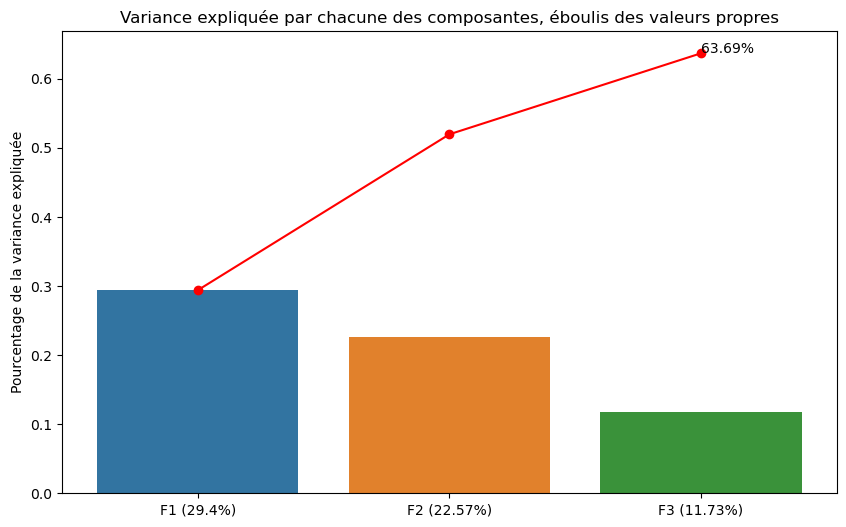

In [47]:
# explication de la variance dans chacune des composantes, éboulis des valeurs propres

cumsum_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize = (10,6))

sns.barplot(x=[n for n in range(pca.components_.shape[0])],
            y=pca.explained_variance_ratio_)

plt.plot([n for n in range(pca.components_.shape[0])], cumsum_variance, c='r', marker='o')


listF = []
for x in range(pca.components_.shape[0]):
    a = f"F{x+1} ({round(100*pca.explained_variance_ratio_[x],2)}%)"
    listF.append(a)
    
plt.text(max([n for n in range(pca.components_.shape[0])]), cumsum_variance.max(), '{:.2%}'.format(round(cumsum_variance.max(),4)))  
plt.title("Variance expliquée par chacune des composantes, éboulis des valeurs propres")
plt.ylabel("Pourcentage de la variance expliquée")
plt.xticks([n for n in range(pca.components_.shape[0])], listF);

68% de la variance est expliquée par les 3 composantes principales, l'ACP est acceptable.

#### Représentation des composantes dans les variables

On cherche à déterminer l'idée principale de chaque composante principale en analysant les combinaisons linéaires de chaque composante.  
On associe chaque variable à la composante par laquelle elle est le plus représentée, on groupe les variables puis en essaie de tirer une idée générale de chaque composante.

Le cercle des corrélations assurera aussi cette fonction.

In [48]:
df_composante = pd.DataFrame(data=pca.components_, index=['F1', 'F2', 'F3'], columns=kmo_col).T
df_composante

F1    F2    F3
production                      0.41 -0.11  0.16
volaille_consommée              0.42 -0.12  0.17
taux_dependance                -0.09  0.32  0.40
taux_autosuffisance             0.08 -0.30 -0.42
proportion_volaille_nourriture  0.04  0.20  0.24
proportion_animaux_nourriture   0.10  0.33  0.22
population                      0.31 -0.19  0.16
lpi                             0.25  0.34 -0.23
pib                             0.41 -0.05  0.13
taux_droit_douane              -0.15 -0.23  0.40
quantite_conteneurs_par_annee   0.36 -0.08  0.21
cout_production_volaille       -0.13  0.06  0.25
taux_population_urbaine         0.16  0.32 -0.26
stabilite_politique             0.05  0.38 -0.04
pib_par_habitant                0.14  0.40 -0.12
classement_consommation        -0.28  0.06  0.25

#### Identification d'une composante principale associée à chaque variable

In [49]:
# on copie df_composante et on sort les variables
df_composante2 = df_composante.reset_index()
df_composante2.rename(columns={'index':'variable'}, inplace=True)

In [50]:
# on pivote les 3 composantes sur une colonne
melt = pd.melt(df_composante2, id_vars='variable', value_vars=['F1','F2','F3'], var_name = 'composantes',
        value_name='correlation')

In [51]:
# valeur absolu correlation
melt['correlation_abs'] = melt['correlation'].abs()

# window function pour avoir le rang de chaque composante
melt['rank'] = melt.groupby(['variable'])['correlation_abs'].rank(ascending=False)

In [52]:
composante_variable = melt[melt['rank']==1][['variable', 'composantes', 'correlation']].reset_index(drop=True)
composante_variable

variable composantes  correlation
0                       production          F1         0.41
1               volaille_consommée          F1         0.42
2                       population          F1         0.31
3                              pib          F1         0.41
4    quantite_conteneurs_par_annee          F1         0.36
5          classement_consommation          F1        -0.28
6    proportion_animaux_nourriture          F2         0.33
7                              lpi          F2         0.34
8          taux_population_urbaine          F2         0.32
9              stabilite_politique          F2         0.38
10                pib_par_habitant          F2         0.40
11                 taux_dependance          F3         0.40
12             taux_autosuffisance          F3        -0.42
13  proportion_volaille_nourriture          F3         0.24
14               taux_droit_douane          F3         0.40
15        cout_production_volaille          F3         0.25

<a id="analyse_composante" ></a>
### Analyse du sens des composantes principales<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

F1 : 
- Associé à la taille du pays, à la richesse globale, au flux économique global et à la quantité globale de volaille consommée.
- On l'associe globalement à la **Puissance commerciale et logistique, Consommation Volaille**.


F2 : 
- Associé à la pauvreté, au non développement urbain et logistique du pays et à la non stabilité politique.
- On l'associe globalement à la **Qualité de vie, Richesse Individuelle**.


F3 : 
- Associé à la présence viande dans la nourriture, à la non auto-suffisance et cout de production assez élevé de la volaille
- On l'associe globalement à **Condition de marché**.

In [53]:
# En résumé
F1_resume = "Puissance commerciale et logistique, Consommation Volaille"
F2_resume = "Qualité de vie, Richesse Individuelle"
F3_resume = "Condition de marché"

resume_composante = [F1_resume, F2_resume, F3_resume]

<a id="resultats" ></a>
## Analyse Résultats<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

<a id="cercle_cor" ></a>
### Cercle de corrélation et Représentation des individus sur le plan factoriel<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [54]:
# représenation des individus sur le plan factoriel
X_projected = pca.transform(X_scaled)

df_projection = pd.DataFrame(data=X_projected, columns=['F1', 'F2', 'F3'], index=pays)
df_projection

F1    F2    F3
Afrique du Sud                                      1.13  0.21 -0.39
Albanie                                            -1.23 -0.06  0.03
Algérie                                            -0.74 -2.19 -0.84
Allemagne                                           2.57  1.63 -1.31
Angola                                             -1.14 -0.73  0.95
Antigua-et-Barbuda                                 -1.64  1.57  3.64
Arabie saoudite                                     0.91  0.94 -0.04
Argentine                                           1.33  0.22 -0.93
Arménie                                            -1.67 -0.31  0.97
Australie                                           1.84  2.22 -1.48
Autriche                                            0.24  2.13 -0.70
Azerbaïdjan                                        -0.98 -1.65 -0.53
Barbade                                            -1.36  0.17  1.92
Belgique                                            0.15  4.26  1.51
Belize                                             -1.46 -1.14  0.60
Bolivie (État plurinational de)                    -0.19 -0.67 -0.42
Bosnie-Herzégovine                                 -0.78 -1.43 -1.27
Botswana                                           -1.01  0.14 -0.80
Brésil                                              5.15 -1.36  0.91
Bulgarie                                           -0.44  0.81 -0.24
Bélarus                                            -0.11 -0.58 -1.39
Bénin                                              -1.36 -0.88  1.17
Cameroun                                           -1.48 -2.76 -0.02
Canada                                              1.88  1.73 -1.76
Chili                                               0.72  0.96 -1.08
Chine - RAS de Hong-Kong                            0.84  7.85  4.39
Chine - RAS de Macao                                0.30  5.26  0.59
Chine, continentale                                15.11 -4.89  4.85
Chypre                                             -0.67  1.24  0.09
Colombie                                            0.55 -0.98 -0.87
Congo                                              -1.36 -0.10  1.63
Congo                                              -1.71 -1.22  2.14
Costa Rica                                         -0.26  0.31 -1.04
Croatie                                            -0.56  0.17 -1.00
Côte d'Ivoire                                      -1.19 -2.04 -0.38
Danemark                                            0.78  2.87 -1.30
Dominique                                          -1.33  1.36  1.54
El Salvador                                        -0.76 -0.69 -0.70
Espagne                                             1.93  0.99 -1.58
Estonie                                            -0.65  1.11 -0.37
Eswatini                                           -1.41 -1.44 -0.31
Fidji                                              -1.87 -0.87  1.73
Finlande                                            0.72  1.72 -2.37
France                                              2.04  1.24 -1.55
Fédération de Russie                                2.08 -1.42 -0.48
Gabon                                              -1.48  0.39  2.28
Ghana                                              -1.19 -1.03  0.67
Grèce                                               0.10  0.21 -1.54
Guatemala                                          -0.54 -0.68 -0.15
Guyana                                             -1.43 -1.49  0.34
Géorgie                                            -1.06 -0.16  0.08
Honduras                                           -0.62 -1.18 -0.50
Hongrie                                             0.26  0.57 -1.41
Inde                                                3.70 -4.09  0.66
Indonésie                                           1.37 -1.61 -0.82
Iran (République islamique d')                      0.32 -2.12  0.18
Iraq                                               -0.97 -1.32  0.94
Irlande                                             

Tous les individus ont été transformés sur le plan factoriel. Ils ont été réduit selon leurs composantes principales.

In [55]:
def correlation_graph(pca, 
                      x_y, 
                      features,
                      resume_composante) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(15, 13))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    axe_x = 'F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1))
    axe_y = 'F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1))
    plt.xlabel(f"{axe_x} : {resume_composante[x]}")
    plt.ylabel(f"{axe_y} : {resume_composante[y]}")

    # # Affichage du titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [56]:
def display_factorial_planes(   X_projected, 
                                x_y,
                                resume_composante,
                                pca=None,
                                labels = None,
                                clusters=None,
                                centroides=None,
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1} : {resume_composante[x]}')
    ax.set_ylabel(f'F{y+1} {v2} : {resume_composante[y]}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')
    
    # On vérifie s'il y a des centroides ou non
    if centroides is None : 
        centroides = []
    if len(centroides) :   
    # visualisation des centroides sous forme de croix rouge
        plt.scatter(centroides[:,x], centroides[:,y], c='r', marker='x', s=100)

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

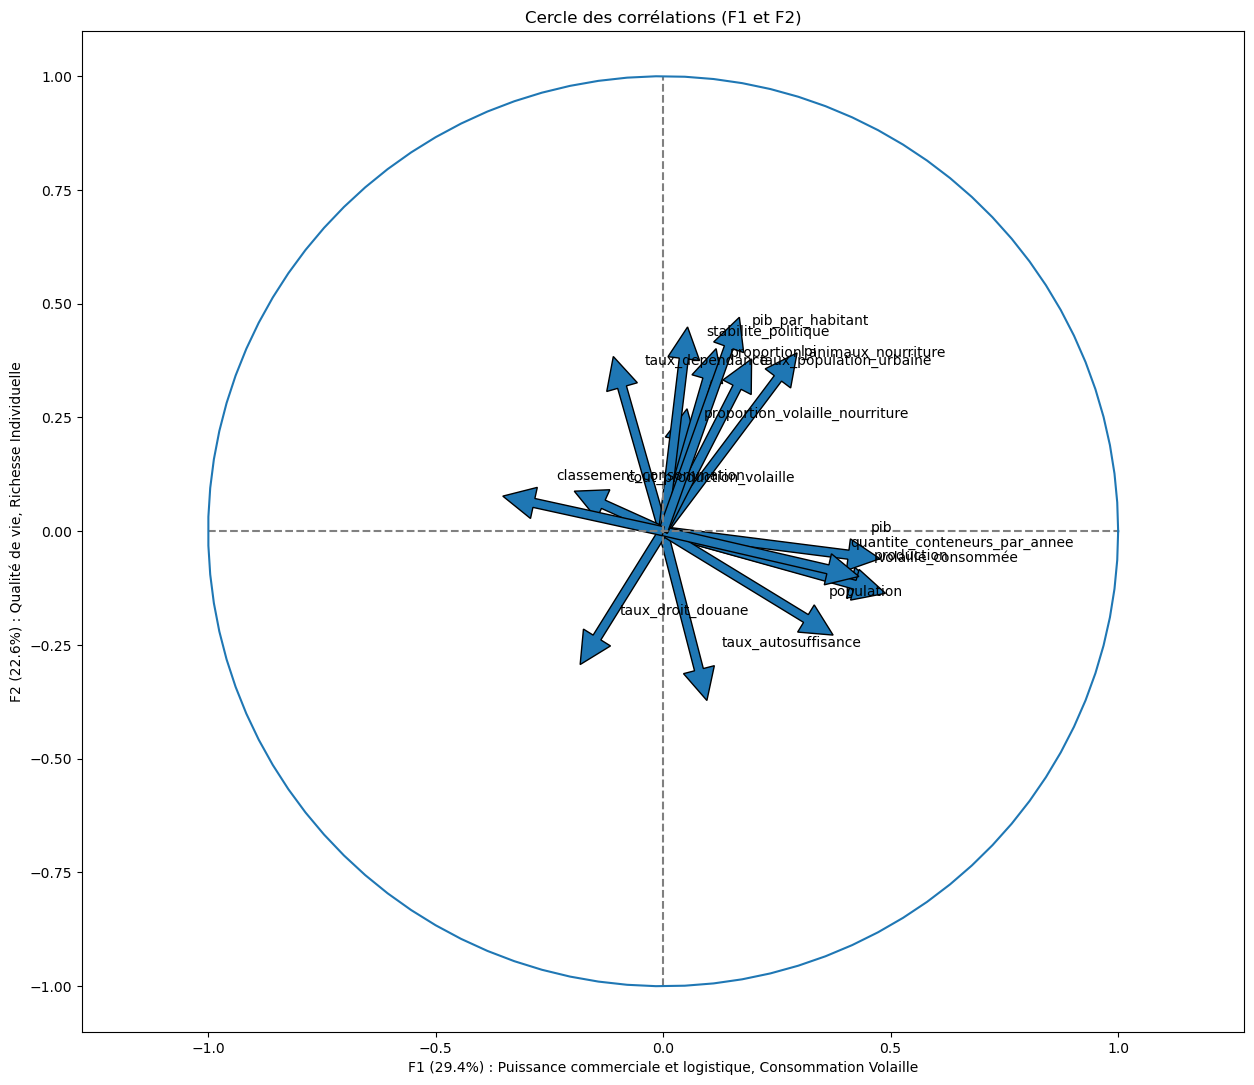

In [57]:
# Plan factoriel composé de F1 et F2
# affichage des variables sur ce plan factoriel
# affichage du cercle des corrélations

x_y = (0,1)
features = kmo_col
correlation_graph(pca, x_y, features, resume_composante)

La moitié supérieur concerne les variables plutôt associées à la Qualité de vie et la Richesse Individuelle (F2).
La partie droite concerne les variables plutôt associées à la Puissance commerciale et logistique et à la Consommation de Volaille (F1).

Sur ce plan factoriel, on cherchera plutôt des pays positionnés entre les 2 groupes de variables, avec une assez forte puissance économique et une bonne qualité de vie. C'est à dire avec un F1 positif plutôt fort et un F2 positif fort (le plus important).
En effet, on priviligiera la Qualité de vie et la Richesse Individuelle sur ce plan factorielle car F1 peut être influencer par les outliers.

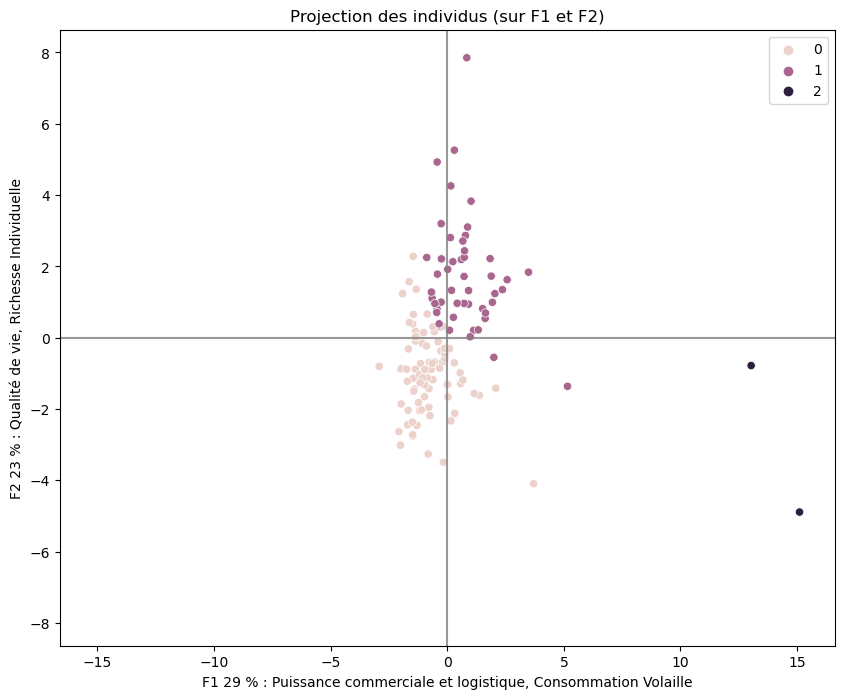

In [58]:
x_y = (0,1)

display_factorial_planes(   X_projected, 
                                x_y,
                                resume_composante,
                                pca=pca,
                                labels = None,
                                clusters=clusters_kmeans,
                                centroides=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." )

On distingue les 4 outliers en bas à droite (Etats Unis, Chine, Inde, Brésil), très grosse puissance global mais par forcément individuellement.


Le clusters bas gauche correspond aux pays "pauvres" ou "peu dévellopés", ils consomment potentiellement peu de volaille et sont moyennement ou peu dévellopés au niveau commercial et logistique (F1 assez faible).  
Leur Qualité de vie et leur Richesse individuelle va de moyenne à faible.


Le clusters haut droit correspond aux pays plutôt "riches" ou "dévellopés", ils consomment de la volaille et sont dévellopés au niveau commercial et logistique (F1 assez fort).  
Leur Qualité de vie et leur Richesse individuelle va de moyenne à élevé.
C'est les pays de ce clusters qu'on priviligiera sur ce plan factoriel.

Pour synthétiser, ici on recherche F1>0 et F2>0

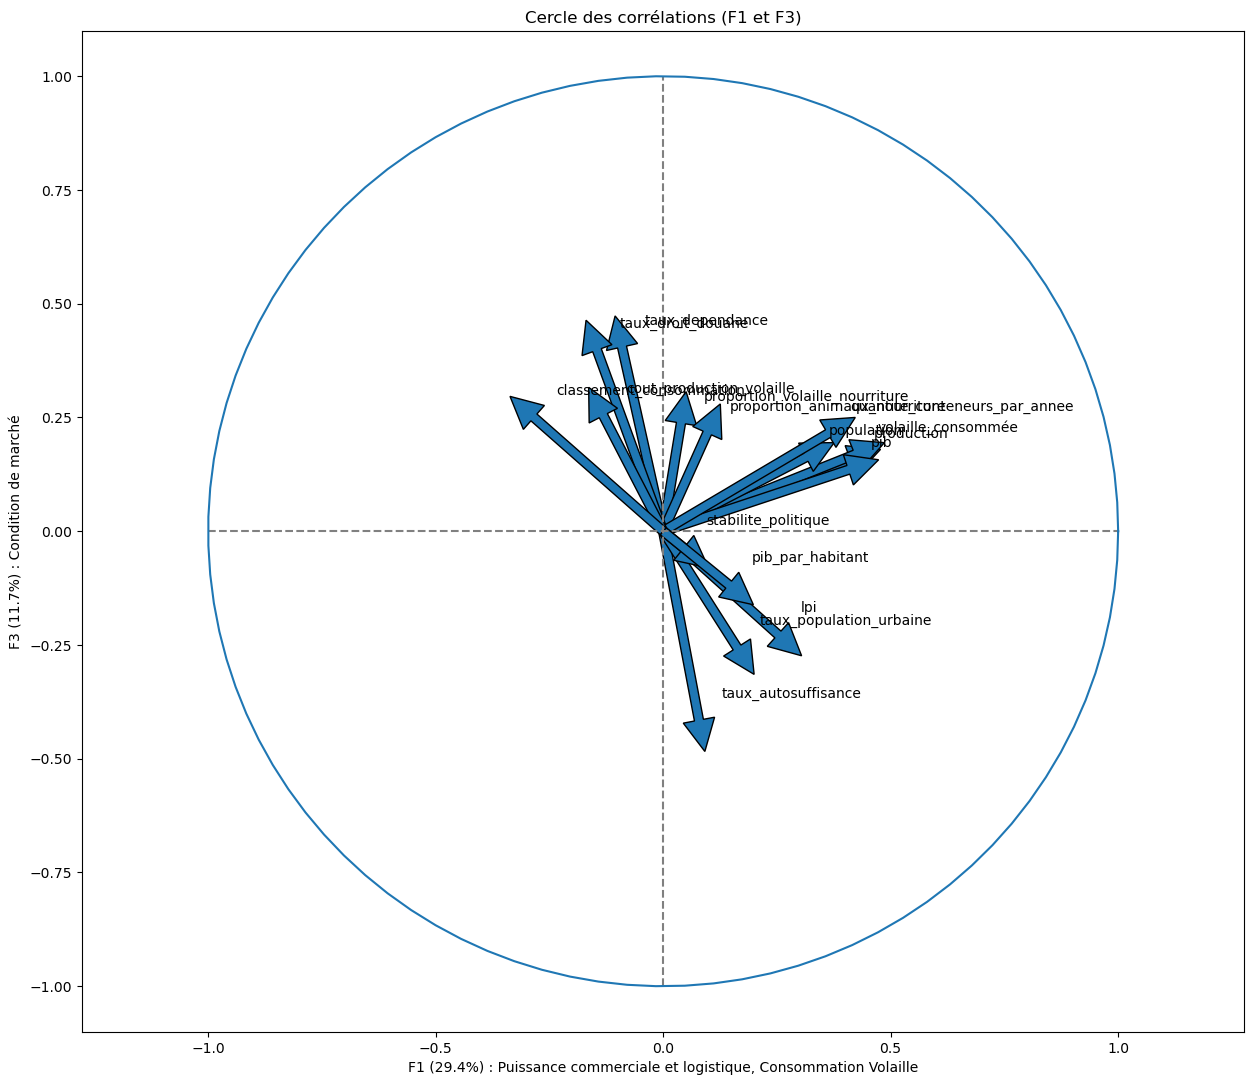

In [59]:
# Cercle des corrélation sur F1 et F3

x_y = (0,2)
correlation_graph(pca, x_y, features, resume_composante)

La moitié supérieur concerne les variables plutôt associées au Condition de Marché (F3).
La partie droite concerne les variables plutôt associées à la Puissance commerciale et logistique et à la Consommation de Volaille (F1) et aussi à la Qualité de vie et à la Richesse Individuelle avec le groupe de variables associé à F2 présent aussi.

Sur ce plan factoriel, on cherchera plutôt des pays positionnés entre les 2 groupes de variables, avec une assez forte puissance économique et des bonnes conditions de marchés. C'est à dire avec un F1 positif et un F3 positif fort.
En effet, on priviligiera les conditions de marché sur ce plan factorielle car F1 peut être influencer par les outliers.

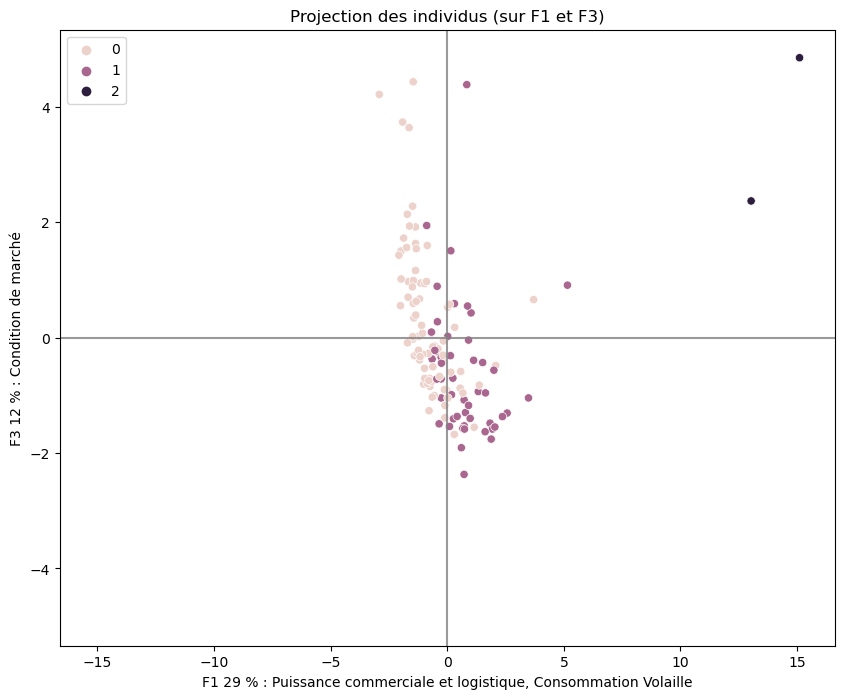

In [60]:
x_y = (0,2)

display_factorial_planes(   X_projected, 
                                x_y,
                                resume_composante,
                                pca=pca, 
                                labels = None,
                                clusters=clusters_kmeans, 
                                centroides=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." )

On distingue les 4 outliers en haut à droite (Etats Unis, Chine, Inde, Brésil), grosse puissance globale et bonne conditions de marché à priori.

Clusters gauche :   
Puissance commerciale et logistique et consommation de volaille plutôt faible.
Condition de marché allant de mauvaise à bonne.

Clusters droit :   
Puissance commerciale et logistique et consommation de volaille plutôt élevé.
Condition de marché allant de mauvaise à bonne.

Pour synthétiser, ici on recherche F1>0 et F3>0

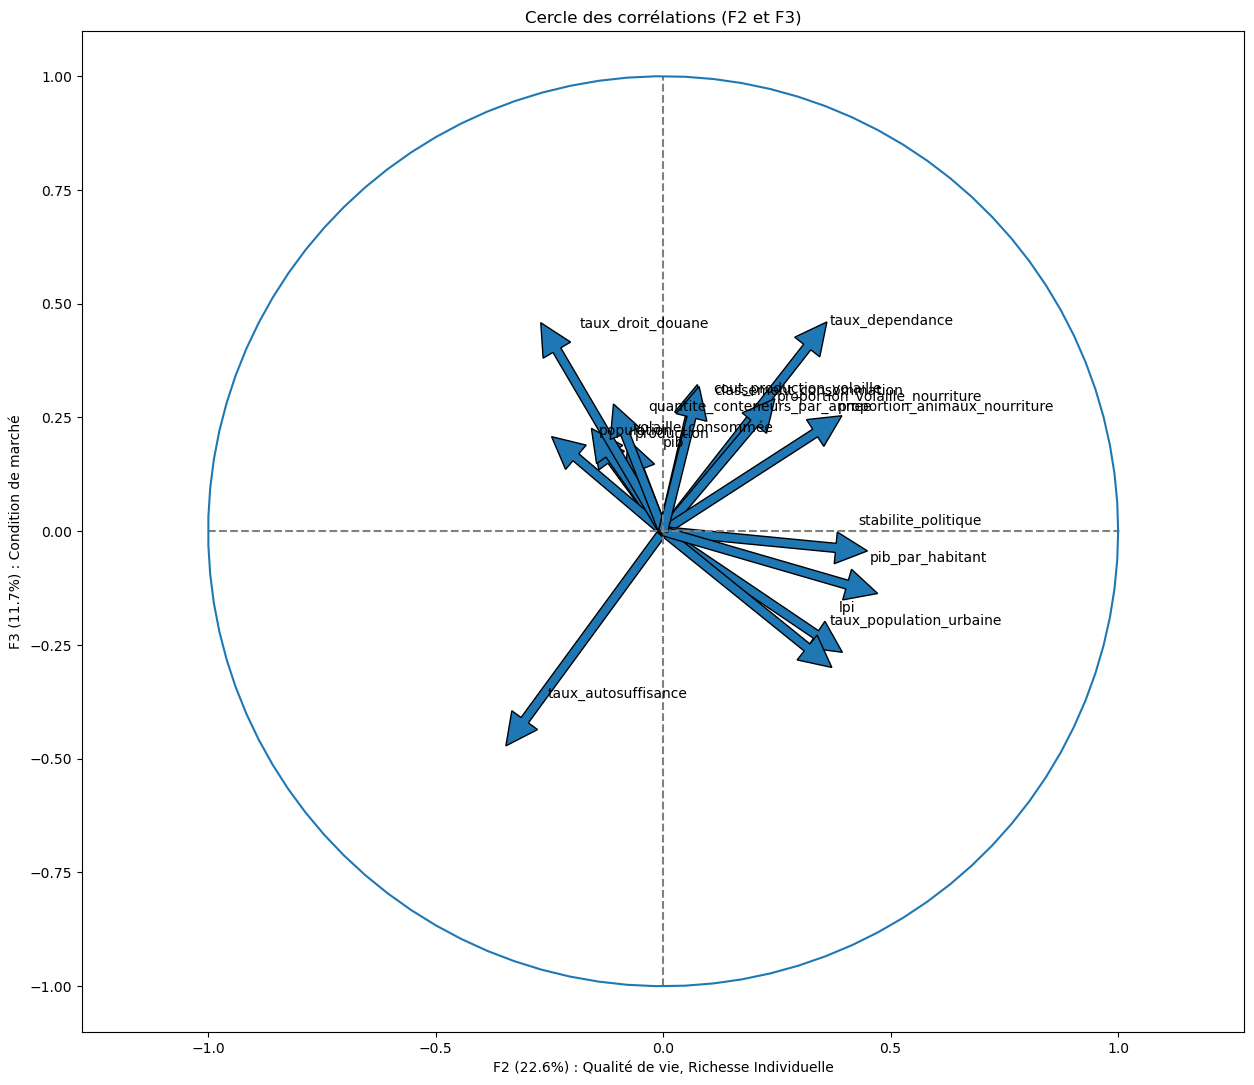

In [61]:
# Cercle des corrélation sur F2 et F3

x_y = (1,2)
correlation_graph(pca, x_y, features, resume_composante)

Partie supérieur : Condition de marché avantageuse

Partie droite : Bonne qualité de vie et richesse individuelle

On veut cibler en priorité la partie droite supérieur soit F2>0 et F3>0.

In [62]:
# En résumé
F1_resume = "Puissance commerciale et logistique, Consommation Volaille"
F2_resume = "Qualité de vie, Richesse Individuelle"
F3_resume = "Condition de marché"

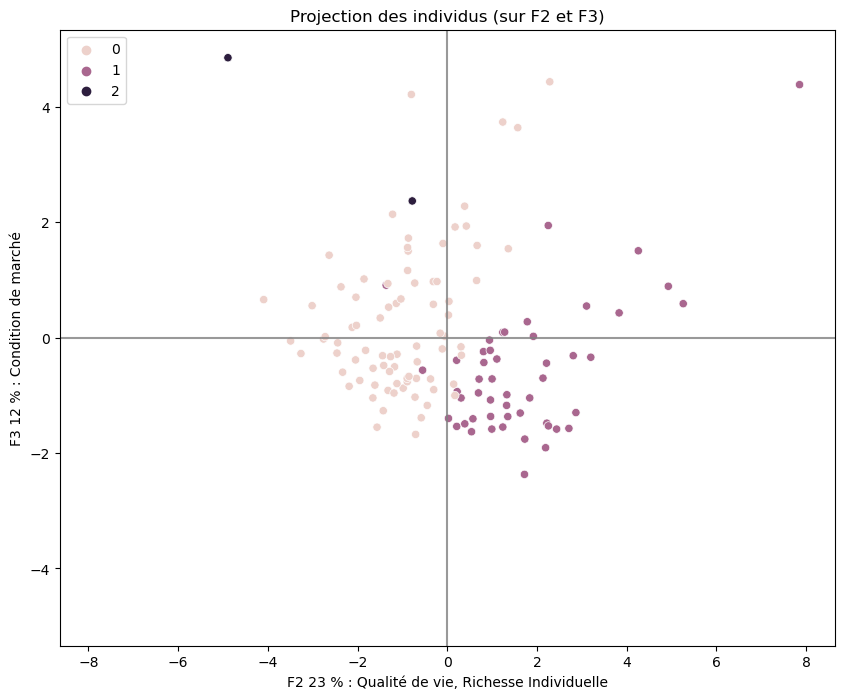

In [63]:
x_y = (1,2)

display_factorial_planes(   X_projected, 
                                x_y,
                                resume_composante,
                                pca=pca, 
                                labels = None,
                                clusters=clusters_kmeans, 
                                centroides=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." )

Clusters outliers :  
Qualité de vie moyenne/Richesse individuelle faible  
Condition de marché plutôt bonne

Clusters gauche :  
Qualité de vie moyenne/Richesse individuelle faible à moyen  
Condition de marché plutôt bonne à faible

Cluster droit :  
Qualité de vie moyenne/Richesse individuelle moyen à élevé  
Conditions de marché bonne à faible

C'est ce dernier clusters qu'on priviligiera en sélectionnant les pays dans le quart supérieur droit.  

En résumé, on cherche les pays avec F2>0, F3>0

<a id="qualite_repr" ></a>
### Qualité de représentation des individus<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

Certains individus sont plus ou moins bien représentés sur le plan factoriel.  
On va voir ici comment mesure cette qualité de représentation.

Pour calculer la qualité de représentation des individus sur les axes, on calcule les carrés des distances à l’origine des individus, qui correspondent également à leur contribution dans l’inertie totale.

Voici la formule :

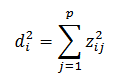

#### Di²

In [64]:
di2 = np.sum(X_scaled**2,axis=1)

df_di2 = pd.DataFrame({'di2':di2}, index=pays)
df_di2.sort_values('di2', ascending=False).head(20)

di2
Chine, continentale      306.00
États-Unis d'Amérique    214.85
Chine - RAS de Hong-Kong 102.43
Inde                      70.32
Luxembourg                63.53
Brésil                    48.63
Saint-Kitts-et-Nevis      45.76
Îles Salomon              39.62
Belgique                  39.14
Islande                   33.33
Chine - RAS de Macao      33.11
Pays-Bas                  27.48
Samoa                     24.95
Antigua-et-Barbuda        24.68
Yémen                     23.58
Japon                     19.48
Tchad                     19.36
Barbade                   18.23
Fidji                     17.33
Suisse                    17.02

Cela semble correspondre aux outliers également.

#### Cos²

Ensuite nous devons calculer le cos² de chaque individu pour chaque composante. Il représente la qualité de représentation par rapport à cette composante.

Ensuite on ajoutera les cos² des 2 composantes principales pour chaque plan factoriel.
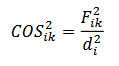

In [65]:
# multiplication de tous les termes par eux même
cos2 = df_projection**2

# application de la formule ci-dessus
for j in range(cos2.columns.shape[0]):    
    cos2.iloc[:,j] = cos2.iloc[:,j]/di2
    
cos2.columns = ['cos2_1', 'cos2_2', 'cos2_3']

cos2['total'] = cos2.sum(axis=1)
cos2.sort_values('total', ascending=False)

cos2_1  cos2_2  cos2_3  \
Chine, continentale                                   0.75    0.08    0.08   
Canada                                                0.33    0.28    0.29   
Togo                                                  0.33    0.49    0.06   
France                                                0.45    0.16    0.26   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...    0.52    0.17    0.17   
Italie                                                0.40    0.04    0.41   
Japon                                                 0.62    0.17    0.06   
Chine - RAS de Macao                                  0.00    0.84    0.01   
Azerbaïdjan                                           0.20    0.57    0.06   
États-Unis d'Amérique                                 0.79    0.00    0.03   
Côte d'Ivoire                                         0.20    0.60    0.02   
Niger                                                 0.24    0.55    0.02   
Libéria                                               0.39    0.10    0.31   
Sénégal                                               0.25    0.54    0.01   
Chine - RAS de Hong-Kong                              0.01    0.60    0.19   
Suède                                                 0.05    0.53    0.22   
Cameroun                                              0.18    0.61    0.00   
Espagne                                               0.40    0.11    0.27   
Samoa                                                 0.15    0.06    0.56   
Émirats arabes unis                                   0.05    0.69    0.02   
Nigéria                                               0.04    0.71    0.01   
Sierra Leone                                          0.36    0.31    0.09   
Maroc                                                 0.00    0.52    0.25   
Kenya                                                 0.17    0.59    0.00   
Finlande                                              0.04    0.25    0.47   
Ouganda                                               0.16    0.59    0.01   
Allemagne                                             0.45    0.18    0.12   
Australie                                             0.24    0.35    0.16   
Tchéquie                                              0.01    0.48    0.26   
Pérou                                                 0.02    0.11    0.62   
Suriname                                              0.30    0.02    0.43   
Antigua-et-Barbuda                                    0.11    0.10    0.54   
Tunisie                                               0.09    0.55    0.08   
Pakistan                                              0.00    0.72    0.00   
Danemark                                              0.04    0.56    0.11   
Algérie                                               0.06    0.56    0.08   
Polynésie française                                   0.06    0.36    0.27   
Tchad                                                 0.22    0.36    0.11   
Indonésie                                             0.25    0.34    0.09   
Îles Salomon                                          0.21    0.02    0.45   
Hongrie                                               0.02    0.09    0.56   
Congo                                                 0.27    0.00    0.39   
Lesotho                                               0.37    0.07    0.21   
Égypte                                                0.00    0.61    0.04   
Portugal                                              0.04    0.20    0.41   
Nouvelle-Zélande                                      0.04    0.40    0.19   
Grèce                                                 0.00    0.01    0.62   
Fédération de Russie                                  0.41    0.19    0.02   
Rwanda                                                0.21    0.42    0.00   
Irlande                                               0.00    0.61    0.01   
Congo                                                 0.20    0.10    0.31

<a id="repr_centroides" ></a>
### Représentation des centroides de chaque clusters<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [66]:
df_centroide_kmeans = pd.DataFrame(pca.transform(centroides), columns=['F1', 'F2', 'F3'])
df_centroide_kmeans

F1    F2    F3
0 -0.80 -1.00  0.27
1  0.73  1.71 -0.58
2 14.07 -2.83  3.61

In [67]:
def projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca) :

    fig, ax = plt.subplots(1, 1, figsize=[7,5])

    x,y = x_y

    markers = ['o', 's', '^', 'v', '+', 'x', '*', 'D']

    X = df_centroide_kmeans.values

    # Valeur x max et y max
    x_max = np.abs(X[:, x]).max() *1.5
    y_max = np.abs(X[:, y]).max() *1.5

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # titre
    plt.title(f"Centroides sur le plan factoriel {df_centroide_kmeans.columns[x]}/{df_centroide_kmeans.columns[y]}")


    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1} : {resume_composante[x]}')
    ax.set_ylabel(f'F{y+1} {v2} : {resume_composante[y]}')

    # point centroides
    for i in range(len(X)):
        plt.scatter(X[i,x], X[i,y], marker=markers[i], label=f'Clusters {range(len(X))[i]}')
    
    # affichage legend
    plt.legend()

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

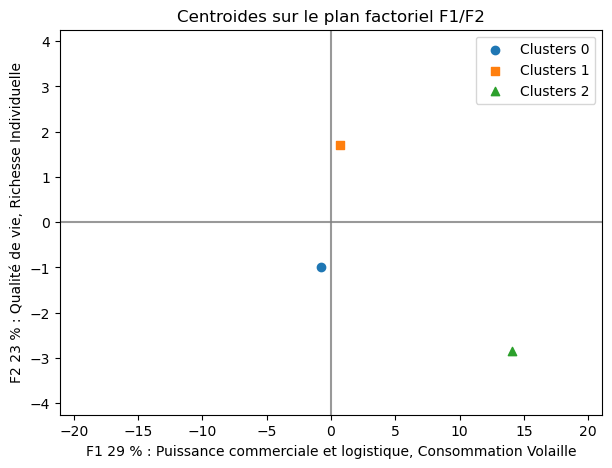

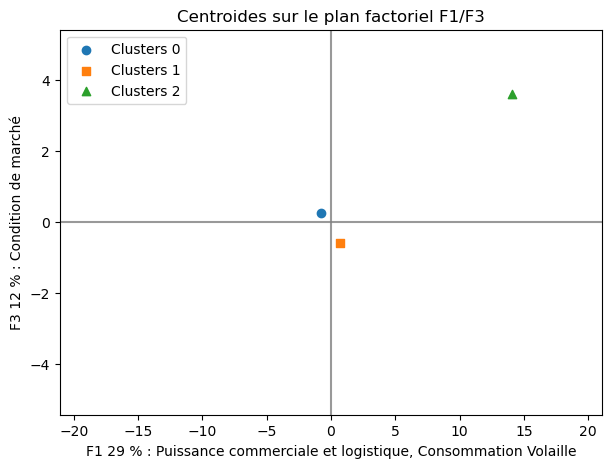

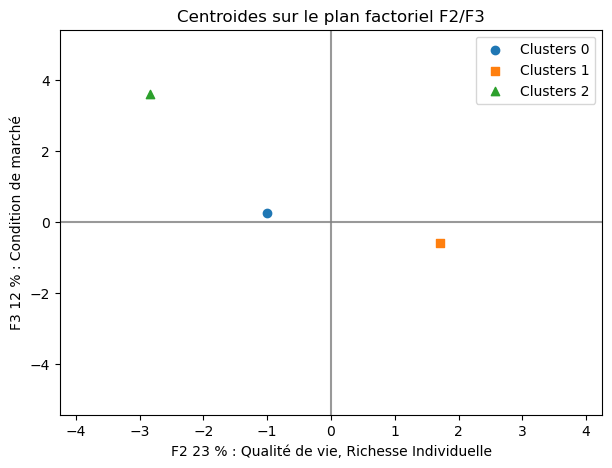

In [68]:
x_y = (0,1)
projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca)

x_y = (0,2)
projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca)

x_y = (1,2)
projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca)

Cluster 0 :  
Puissance commerciale et logistique, Consommation Volaille -  
Qualité de vie, Richesse Individuelle -  
Condition de marché +  


Cluster 1 :  
Puissance commerciale et logistique, Consommation Volaille ++  
Qualité de vie, Richesse Individuelle -  
Condition de marché ++  


Cluster 2 :  
Puissance commerciale et logistique, Consommation Volaille +  
Qualité de vie, Richesse Individuelle -  
Condition de marché -  

Ces constats prennent les clusters dans leur ensemble, hors, on a vu qu'il y a une partie du clusters 2 qui est très intéressante.

De plus, on sait que l'ACP est sensible aux outliers, cela peut déséquilibrer l'ensemble.

On va donc procéder à une nouvelle itération en retirant les outliers et en modifiant certains paramètres.

<a id="repr_3d" ></a>
### Représentation 3D<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [69]:
title = "Représentation des pays en fonction des 3 composantes principales"

fig = px.scatter_3d(x=X_projected[:,0], y=X_projected[:,1], z=X_projected[:, 2], hover_name=pays,
              color=clusters_kmeans, title=title, labels={'x':'F1', 'y':'F2', 'z':'F3'})
fig.show()

<a id="carte" ></a>
### Visualisation des clusters sur la carte<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [70]:
# importation latitude et longitude
coordonnees = pd.read_csv(folder+'latitude_longitude.csv', sep=';')
coordonnees.columns = ['pays', 'latitude', 'longitude', 'clusters']

In [71]:
coordonnees = coordonnees[['pays', 'latitude', 'longitude']]

In [72]:
# df avec les coordonnées gps
df_carte = df.merge(coordonnees, how='left', on='pays')
df_carte.head()

pays  exportation_volaille  importation_volaille   production  \
0  Afrique du Sud             63,000.00            514,000.00 1,667,000.00   
1         Albanie                  0.00             38,000.00    13,000.00   
2         Algérie                  0.00              2,000.00   275,000.00   
3       Allemagne            646,000.00            842,000.00 1,514,000.00   
4          Angola                  0.00            277,000.00    42,000.00   

   volaille_consommée  taux_dependance  taux_autosuffisance  \
0        2,035,000.00             0.24                 0.76   
1           47,000.00             0.81                 0.28   
2          264,000.00             0.01                 0.99   
3        1,609,000.00             0.48                 0.50   
4          315,000.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  \
0                            0.06                           0.12   
1                            0.01                           0.05   
2                            0.01                           0.03   
3                            0.02                           0.10   
4                            0.02                           0.07   

     population  ...  quantite_conteneurs_par_annee  cout_production_volaille  \
0 57,009,756.00  ...                   4,563,618.00                  2,016.60   
1  2,884,169.00  ...                     118,270.00                  2,072.14   
2 41,389,189.00  ...                   1,725,238.00                  2,180.70   
3 82,658,409.00  ...                  15,169,595.00                  1,459.50   
4 29,816,766.00  ...                     570,200.00                  2,176.24   

   taux_population_urbaine  stabilite_politique  pib_par_habitant  \
0                     0.66                -0.28          6,690.94   
1                     0.60                 0.38          4,514.19   
2                     0.72                -0.92          4,109.70   
3                     0.77                 0.59         44,651.83   
4                     0.65                -0.33          2,313.22   

   classement_consommation  clusters_cah  clusters_kmeans  latitude  longitude  
0                    10.00             2                1     -31,7     23,441  
1                   101.50             1                0    40,654     20,076  
2                    51.50             1                0   28,6045       2,64  
3                    15.00             2                1   51,3819     9,9877  
4                    48.50             1                0   -12,836     17,808  

[5 rows x 25 columns]

In [73]:
code_iso_3 = {
    'Afrique du Sud': 'ZAF',
    'Albanie': 'ALB',
    'Algérie': 'DZA',
    'Allemagne': 'DEU',
    'Angola': 'AGO',
    'Antigua-et-Barbuda': 'ATG',
    'Arabie saoudite': 'SAU',
    'Argentine': 'ARG',
    'Arménie': 'ARM',
    'Australie': 'AUS',
    'Autriche': 'AUT',
    'Azerbaïdjan': 'AZE',
    'Barbade': 'BRB',
    'Belgique': 'BEL',
    'Belize': 'BLZ',
    'Bolivie (État plurinational de)': 'BOL',
    'Bosnie-Herzégovine': 'BIH',
    'Botswana': 'BWA',
    'Brésil': 'BRA',
    'Bulgarie': 'BGR',
    'Bélarus': 'BLR',
    'Bénin': 'BEN',
    'Cameroun': 'CMR',
    'Canada': 'CAN',
    'Chili': 'CHL',
    'Chine - RAS de Hong-Kong': 'HKG',
    'Chine - RAS de Macao': 'MAC',
    'Chine, continentale': 'CHN',
    'Chypre': 'CYP',
    'Colombie': 'COL',
    'Congo': 'COG',
    'Costa Rica': 'CRI',
    'Croatie': 'HRV',
    "Côte d'Ivoire": 'CIV',
    'Danemark': 'DNK',
    'Dominique': 'DMA',
    'El Salvador': 'SLV',
    'Espagne': 'ESP',
    'Estonie': 'EST',
    'Eswatini': 'SWZ',
    'Fidji': 'FJI',
    'Finlande': 'FIN',
    'France': 'FRA',
    'Fédération de Russie': 'RUS',
    'Gabon': 'GAB',
    'Ghana': 'GHA',
    'Grèce': 'GRC',
    'Guatemala': 'GTM',
    'Guyana': 'GUY',
    'Géorgie': 'GEO',
    'Honduras': 'HND',
    'Hongrie': 'HUN',
    'Inde': 'IND',
    'Indonésie': 'IDN',
    "Iran (République islamique d')": 'IRN',
    'Iraq': 'IRQ',
    'Irlande': 'IRL',
    'Islande': 'ISL',
    'Israël': 'ISR',
    'Italie': 'ITA',
    'Jamaïque': 'JAM',
    'Japon': 'JPN',
    'Jordanie': 'JOR',
    'Kazakhstan': 'KAZ',
    'Kenya': 'KEN',
    'Koweït': 'KWT',
    'Lesotho': 'LSO',
    'Lettonie': 'LVA',
    'Liban': 'LBN',
    'Libéria': 'LBR',
    'Lituanie': 'LTU',
    'Luxembourg': 'LUX',
    'Macédoine du Nord': 'MKD',
    'Malaisie': 'MYS',
    'Malte': 'MLT',
    'Maroc': 'MAR',
    'Maurice': 'MUS',
    'Mexique': 'MEX',
    'Monténégro': 'MNE',
    'Myanmar': 'MMR',
    'Namibie': 'NAM',
    'Nicaragua': 'NIC',
    'Niger': 'NER',
    'Nigéria': 'NGA',
    'Norvège': 'NOR',
    'Nouvelle-Zélande': 'NZL',
    'Oman': 'OMN',
    'Ouganda': 'UGA',
    'Pakistan': 'PAK',
    'Panama': 'PAN',
    'Paraguay': 'PRY',
    'Pays-Bas': 'NLD',
    'Philippines': 'PHL',
    'Pologne': 'POL',
    'Polynésie française': 'PYF',
    'Portugal': 'PRT',
    'Pérou': 'PER',
    'Roumanie': 'ROU',
    "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord": 'GBR',
    'Rwanda': 'RWA',
    'République de Corée': 'KOR',
    'République de Moldova': 'MDA',
    'République dominicaine': 'DOM',
    'Saint-Kitts-et-Nevis': 'KNA',
    'Samoa': 'WSM',
    'Serbie': 'SRB',
    'Sierra Leone': 'SLE',
    'Slovaquie': 'SVK',
    'Slovénie': 'SVN',
    'Sri Lanka': 'LKA',
    'Suisse': 'CHE',
    'Suriname': 'SUR',
    'Suède': 'SWE',
    'Sénégal': 'SEN',
    'Tchad': 'TCD',
    'Tchéquie': 'CZE',
    'Thaïlande': 'THA',
    'Togo': 'TGO',
    'Trinité-et-Tobago': 'TTO',
    'Tunisie': 'TUN',
    'Turquie': 'TUR',
    'Ukraine': 'UKR',
    'Uruguay': 'URY',
    'Viet Nam': 'VNM',
    'Yémen': 'YEM',
    'Zambie': 'ZMB',
    'Égypte': 'EGY',
    'Émirats arabes unis': 'ARE',
    'Équateur': 'ECU',
    "États-Unis d'Amérique": 'USA',
    'Îles Salomon': 'SLB'
}

In [74]:
# df code iso
code_iso = pd.DataFrame(data=code_iso_3, index=['code_iso']).T.reset_index().rename(columns={'index' : 'pays'})

In [75]:
# jointure df carte
df_carte = df_carte.merge(code_iso, how='left', on='pays')

In [76]:
len(df_carte['clusters_kmeans'].unique())

3

In [77]:
# création de la carte
fig = px.choropleth(df_carte, color='clusters_kmeans', locations='code_iso',
                    hover_name='pays', title='Carte des clusters', scope='world')
fig.show()

<a id="pays_clusters" ></a>
### Analyse des pays par clusters<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [78]:
# df analyse finale
col_finale = np.insert(kmo_col, 0, ['pays', 'clusters_kmeans'])
df_final = df[col_finale]
df_final = df_final.set_index('pays')
df_final.head()

clusters_kmeans   production  volaille_consommée  \
pays                                                               
Afrique du Sud                1 1,667,000.00        2,035,000.00   
Albanie                       0    13,000.00           47,000.00   
Algérie                       0   275,000.00          264,000.00   
Allemagne                     1 1,514,000.00        1,609,000.00   
Angola                        0    42,000.00          315,000.00   

                taux_dependance  taux_autosuffisance  \
pays                                                   
Afrique du Sud             0.24                 0.76   
Albanie                    0.81                 0.28   
Algérie                    0.01                 0.99   
Allemagne                  0.48                 0.50   
Angola                     0.87                 0.13   

                proportion_volaille_nourriture  proportion_animaux_nourriture  \
pays                                                                            
Afrique du Sud                            0.06                           0.12   
Albanie                                   0.01                           0.05   
Algérie                                   0.01                           0.03   
Allemagne                                 0.02                           0.10   
Angola                                    0.02                           0.07   

                  population  lpi                  pib  taux_droit_douane  \
pays                                                                        
Afrique du Sud 57,009,756.00 3.57   381,448,814,653.46               4.44   
Albanie         2,884,169.00 2.56    13,019,689,336.69               1.43   
Algérie        41,389,189.00 2.52   170,097,014,589.13               9.28   
Allemagne      82,658,409.00 4.13 3,690,849,152,517.65               1.81   
Angola         29,816,766.00 2.24    68,972,769,395.63               8.52   

                quantite_conteneurs_par_annee  cout_production_volaille  \
pays                                                                      
Afrique du Sud                   4,563,618.00                  2,016.60   
Albanie                            118,270.00                  2,072.14   
Algérie                          1,725,238.00                  2,180.70   
Allemagne                       15,169,595.00                  1,459.50   
Angola                             570,200.00                  2,176.24   

                taux_population_urbaine  stabilite_politique  \
pays                                                           
Afrique du Sud                     0.66                -0.28   
Albanie                            0.60                 0.38   
Algérie                            0.72                -0.92   
Allemagne                          0.77                 0.59   
Angola                             0.65                -0.33   

                pib_par_habitant  classement_consommation  
pays                                                       
Afrique du Sud          6,690.94                    10.00  
Albanie                 4,514.19                   101.50  
Algérie                 4,109.70                    51.50  
Allemagne              44,651.83                    15.00  
Angola                  2,313.22                    48.50

Distribution des variables pour chaque clusters


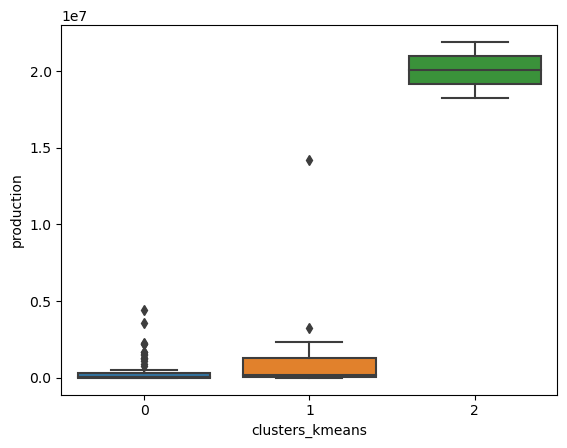

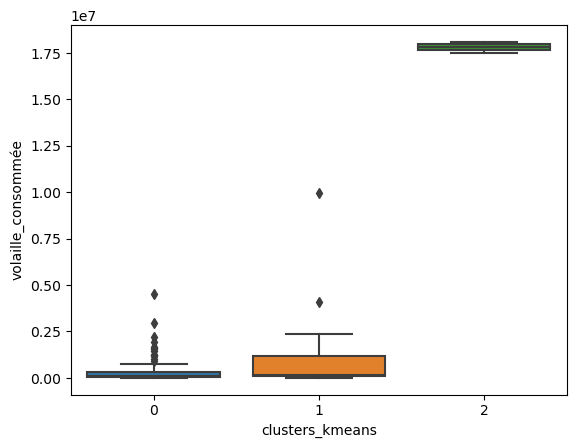

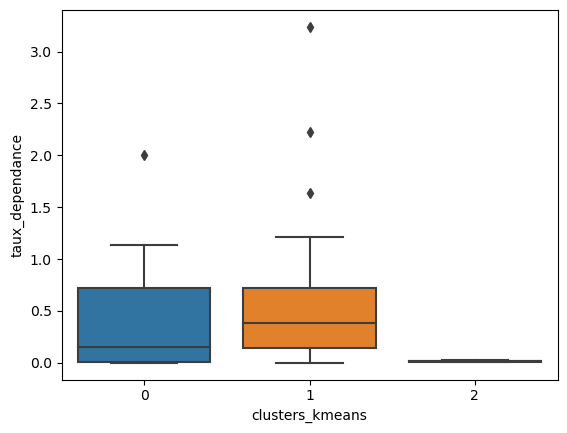

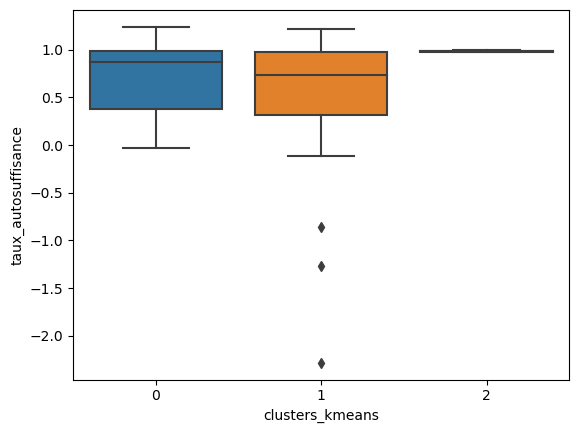

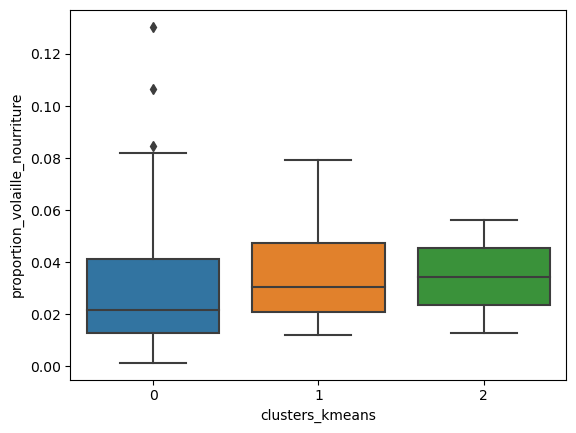

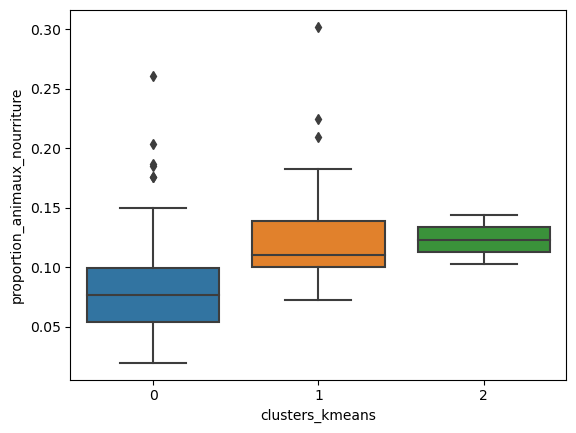

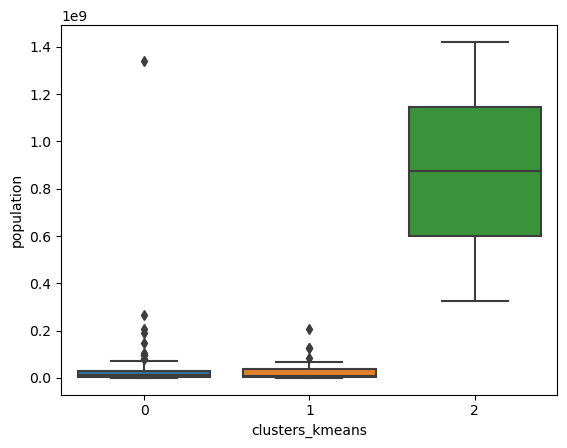

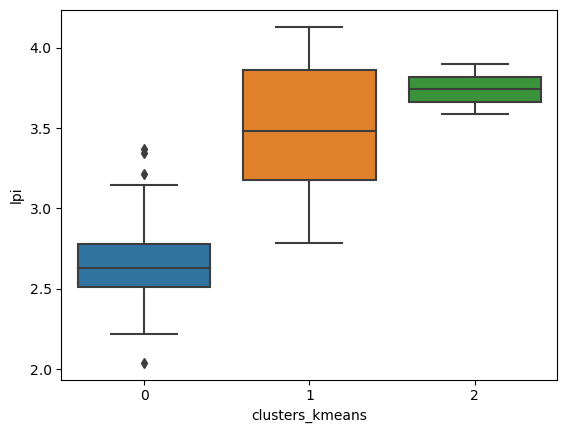

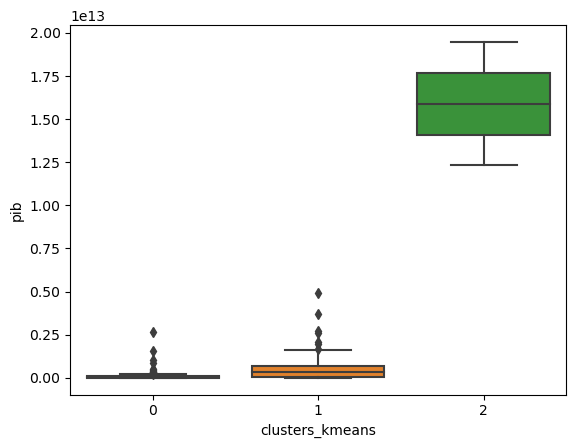

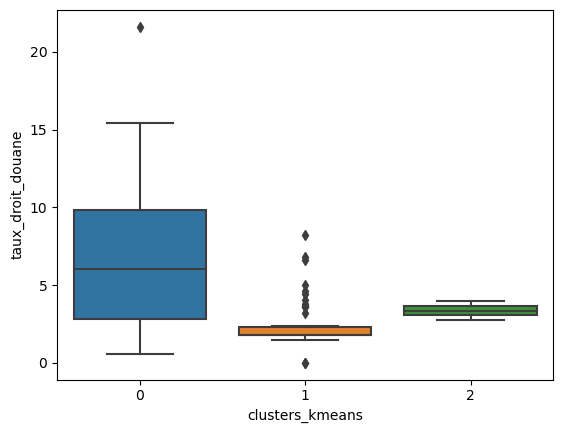

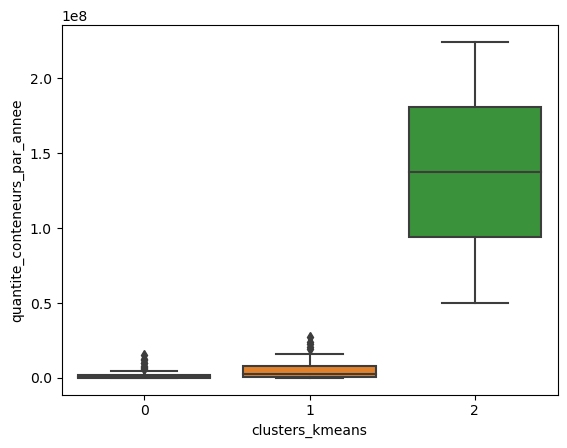

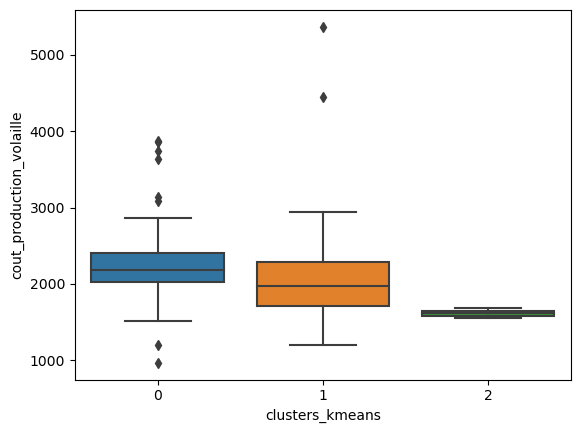

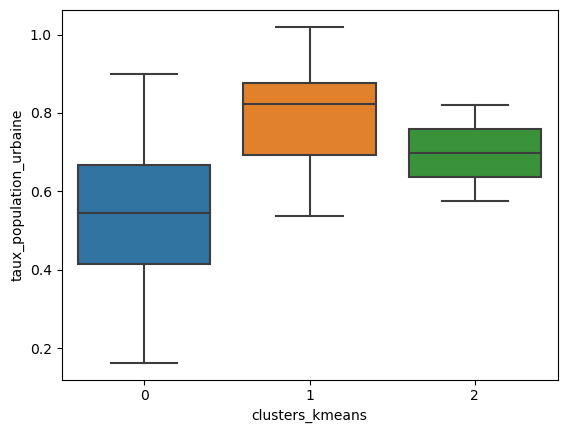

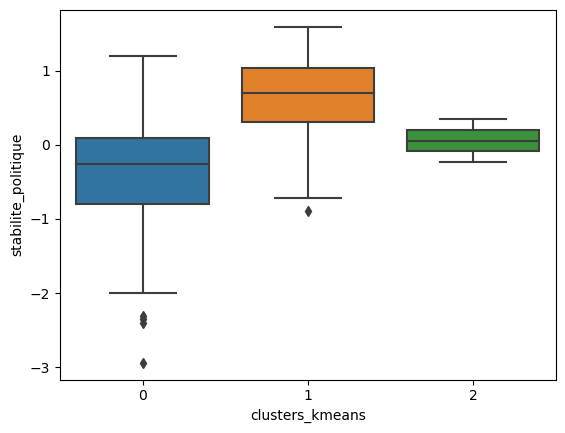

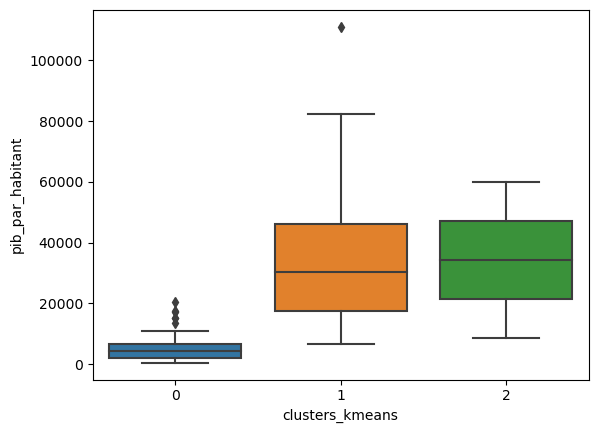

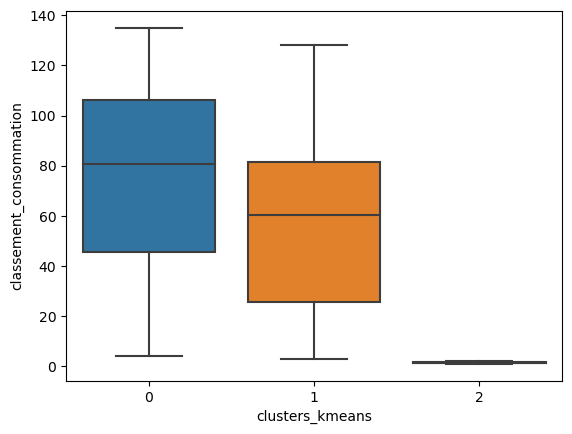

In [79]:
# Distribution des variable pour chaque clusters
print("Distribution des variables pour chaque clusters")

for col in df_final.drop(columns='clusters_kmeans'):
    sns.boxplot(data=df_final, y=col, x='clusters_kmeans')
    plt.show()

Ces graphiques que c'est le clusters 2 qui est le plus intéressant pour implanter un nouveau marché.  
On va voir plus en détails les pays qui composent ce clusters.

### Pays Clusters 2

In [80]:
df_final[df_final['clusters_kmeans'] == 2].head()

clusters_kmeans    production  volaille_consommée  \
pays                                                                       
Chine, continentale                  2 18,236,000.00       17,518,000.00   
États-Unis d'Amérique                2 21,914,000.00       18,100,000.00   

                       taux_dependance  taux_autosuffisance  \
pays                                                          
Chine, continentale               0.02                 0.97   
États-Unis d'Amérique             0.01                 1.00   

                       proportion_volaille_nourriture  \
pays                                                    
Chine, continentale                              0.01   
États-Unis d'Amérique                            0.06   

                       proportion_animaux_nourriture       population  lpi  \
pays                                                                         
Chine, continentale                             0.10 1,421,021,791.00 3.59   
États-Unis d'Amérique                           0.14   325,084,756.00 3.90   

                                        pib  taux_droit_douane  \
pays                                                             
Chine, continentale   12,310,409,370,892.76               3.96   
États-Unis d'Amérique 19,477,336,549,000.00               2.75   

                       quantite_conteneurs_par_annee  \
pays                                                   
Chine, continentale                   224,117,874.00   
États-Unis d'Amérique                  50,202,917.00   

                       cout_production_volaille  taux_population_urbaine  \
pays                                                                       
Chine, continentale                    1,681.40                     0.57   
États-Unis d'Amérique                  1,551.86                     0.82   

                       stabilite_politique  pib_par_habitant  \
pays                                                           
Chine, continentale                  -0.23          8,663.07   
États-Unis d'Amérique                 0.34         59,914.64   

                       classement_consommation  
pays                                            
Chine, continentale                       2.00  
États-Unis d'Amérique                     1.00

<a id="prop" ></a>
### Proposition de pays<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [81]:
df_projection['clusters_kmeans'] = clusters_kmeans

In [82]:
# sélection des pays selon les conditions indiquées plus haut
mask = (df_projection['F1']>0)&(df_projection['F2']>0)&(df_projection['F3']>0)

In [83]:
df_projection[mask]

F1   F2   F3  clusters_kmeans
Belgique                 0.15 4.26 1.51                1
Chine - RAS de Hong-Kong 0.84 7.85 4.39                1
Chine - RAS de Macao     0.30 5.26 0.59                1
Koweït                   0.02 1.92 0.02                1
Pays-Bas                 1.02 3.83 0.43                1
Émirats arabes unis      0.87 3.10 0.55                1

100% des pays qui réunissent les conditions appartiennent au cluster 2.  
Les pays européens présélectionnées ont l'avantage de la proximité géographique.  
Macao et Hong Kong sont potentiellement fournis exclusivement pas la Chine.  
Les Émirats arabes unis peuvent être intéressant également.  

Nous allons voir plus en détails les variables pour ces pays.

In [84]:
# on rajoute toutes les colonnes pour comparer la présélection
df_final2 = df.set_index('pays').drop(columns=['clusters_cah', 'clusters_kmeans'])

In [85]:
preselection = df_final2.loc[list(df_projection[mask].index)]
preselection

exportation_volaille  importation_volaille  \
pays                                                                   
Belgique                            656,000.00            338,000.00   
Chine - RAS de Hong-Kong            663,000.00            907,000.00   
Chine - RAS de Macao                      0.00             23,000.00   
Koweït                                4,000.00            137,000.00   
Pays-Bas                          1,418,000.00            608,000.00   
Émirats arabes unis                  94,000.00            433,000.00   

                           production  volaille_consommée  taux_dependance  \
pays                                                                         
Belgique                   463,000.00          144,000.00             2.22   
Chine - RAS de Hong-Kong    24,000.00          391,000.00             3.24   
Chine - RAS de Macao         3,000.00           21,000.00             1.21   
Koweït                      56,000.00          188,000.00             0.72   
Pays-Bas                 1,100,000.00          346,000.00             1.63   
Émirats arabes unis         48,000.00          412,000.00             1.05   

                          taux_autosuffisance  proportion_volaille_nourriture  \
pays                                                                            
Belgique                                -1.27                            0.01   
Chine - RAS de Hong-Kong                -2.28                            0.07   
Chine - RAS de Macao                     0.16                            0.05   
Koweït                                   0.28                            0.07   
Pays-Bas                                -0.85                            0.02   
Émirats arabes unis                     -0.11                            0.07   

                          proportion_animaux_nourriture    population  \
pays                                                                    
Belgique                                           0.08 11,419,748.00   
Chine - RAS de Hong-Kong                           0.30  7,306,322.00   
Chine - RAS de Macao                               0.22    622,585.00   
Koweït                                             0.11  4,056,099.00   
Pays-Bas                                           0.09 17,021,347.00   
Émirats arabes unis                                0.13  9,487,203.00   

                          accroissement_population_moyen_par_annee  \
pays                                                                 
Belgique                                                 63,165.53   
Chine - RAS de Hong-Kong                                 40,284.37   
Chine - RAS de Macao                                     10,729.16   
Koweït                                                  110,115.21   
Pays-Bas                                                 59,651.16   
Émirats arabes unis                                     341,941.95   

                          taux_accroissement_population_moyen  lpi  \
pays                                                                 
Belgique                                                 0.01 4.02   
Chine - RAS de Hong-Kong                                 0.01 3.97   
Chine - RAS de Macao                                     0.02 3.58   
Koweït                                                   0.03 3.06   
Pays-Bas                                                 0.00 4.07   
Émirats arabes unis                                      0.04 3.81   

                                        pib  taux_droit_douane  \
pays                                                             
Belgique                 502,764,720,556.35               1.81   
Chine - RAS de Hong-Kong 341,273,289,534.47               0.00   
Chine - RAS de Macao      50,440,941,938.70               0.00   
Koweït                   120,707,435,542.37               3.79   
Pays-Bas                 833,869,641,687.06               1.81   
Émirat

Distribution des variables


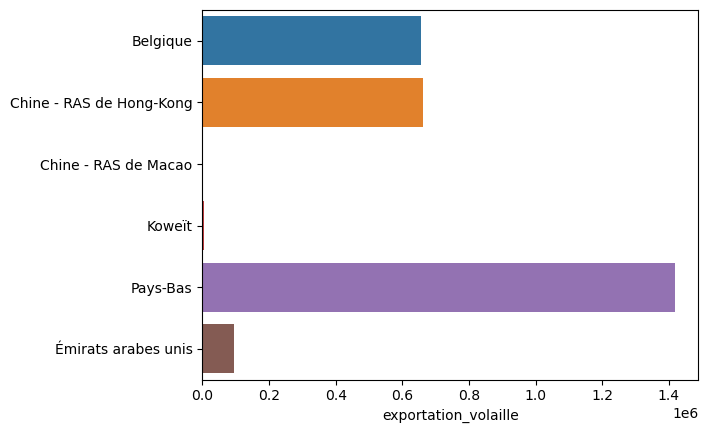

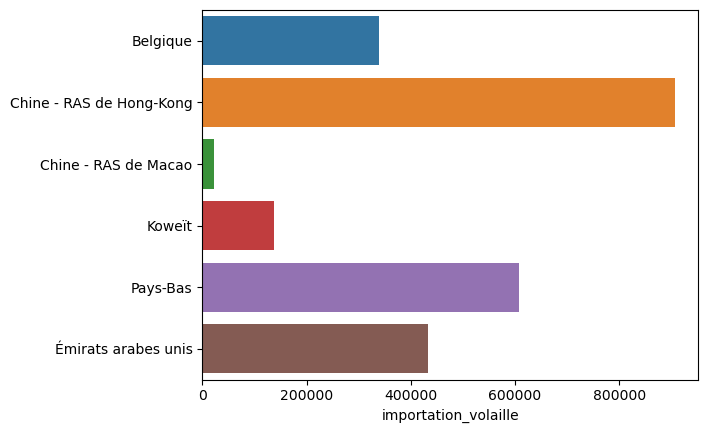

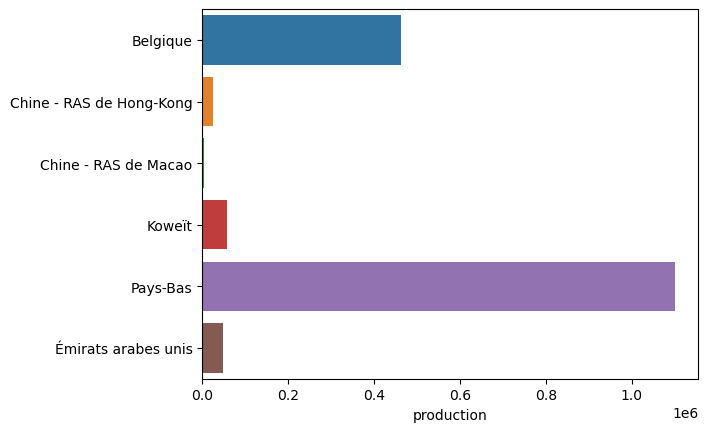

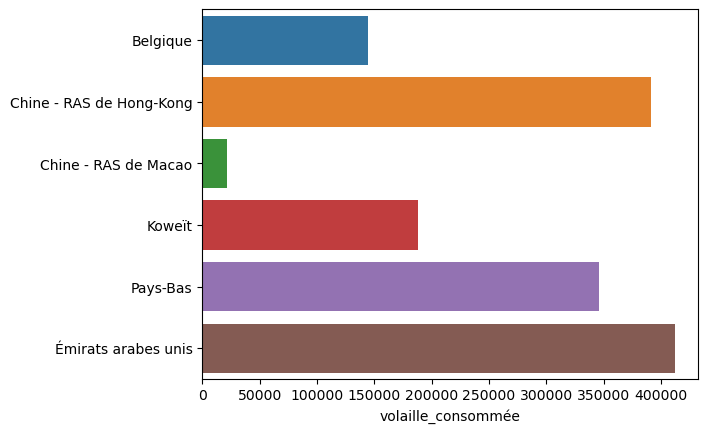

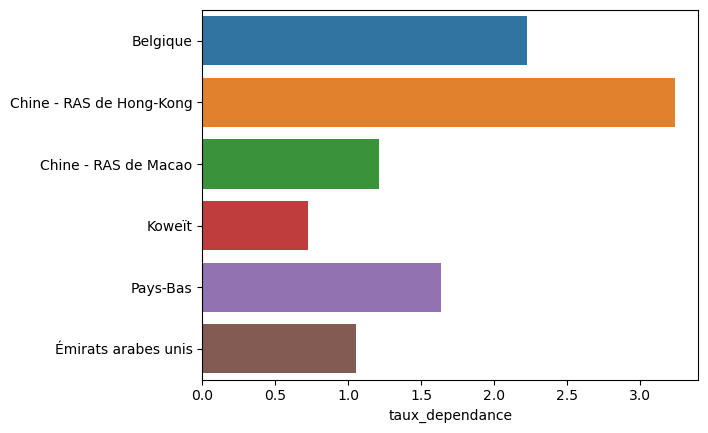

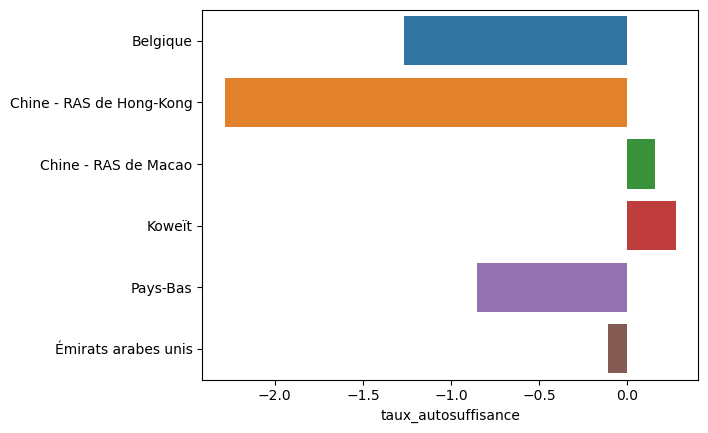

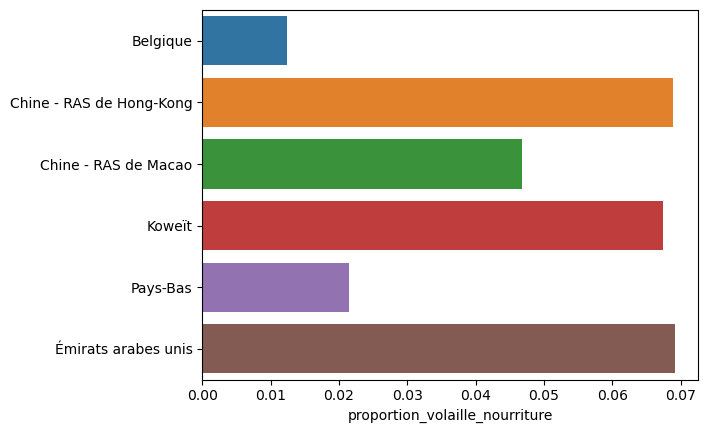

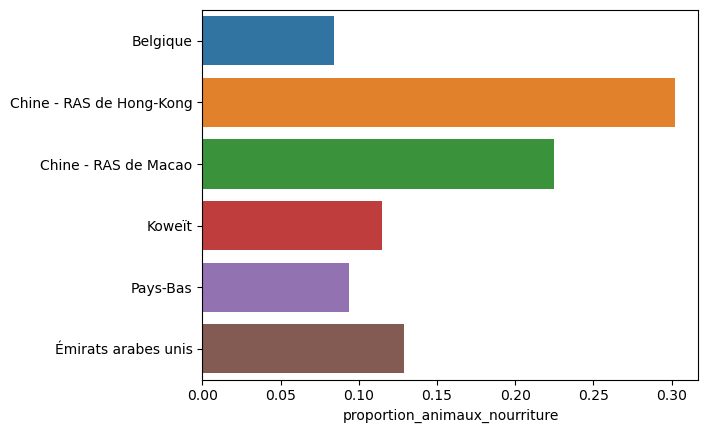

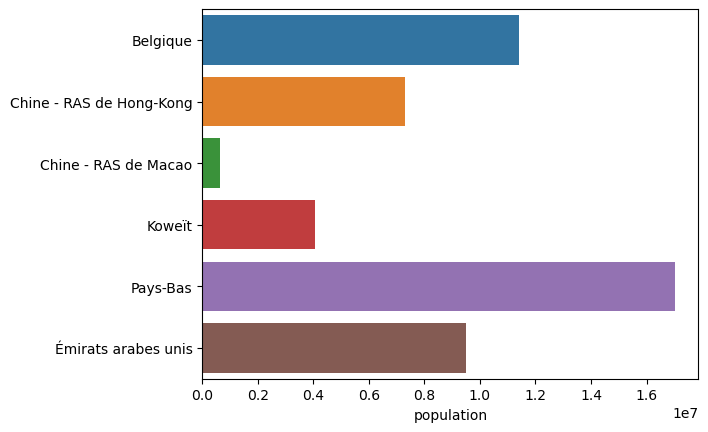

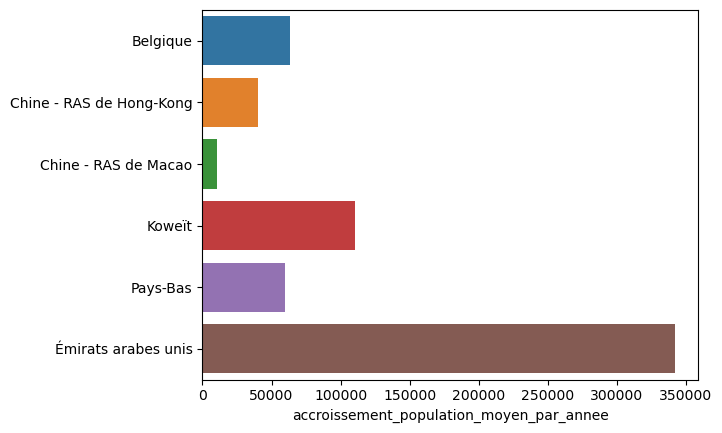

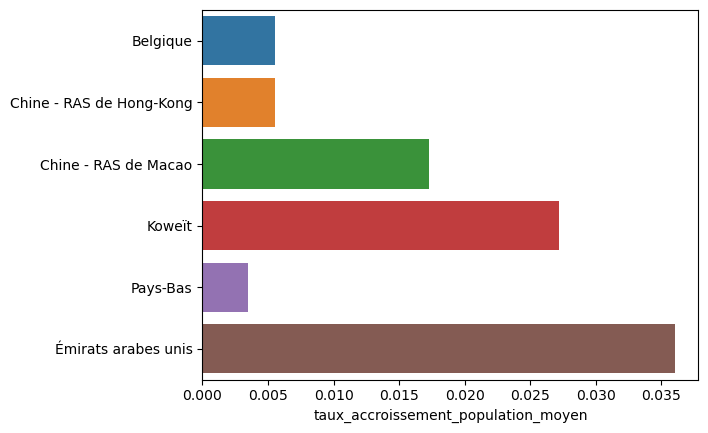

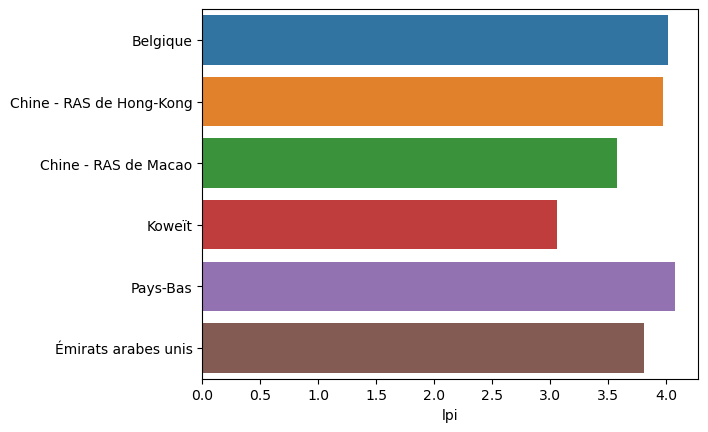

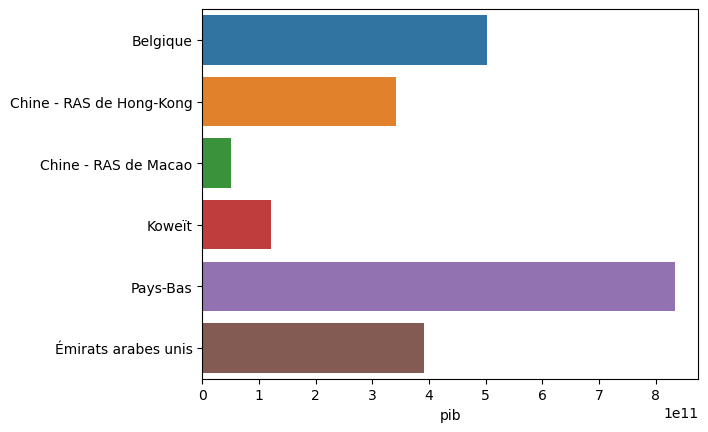

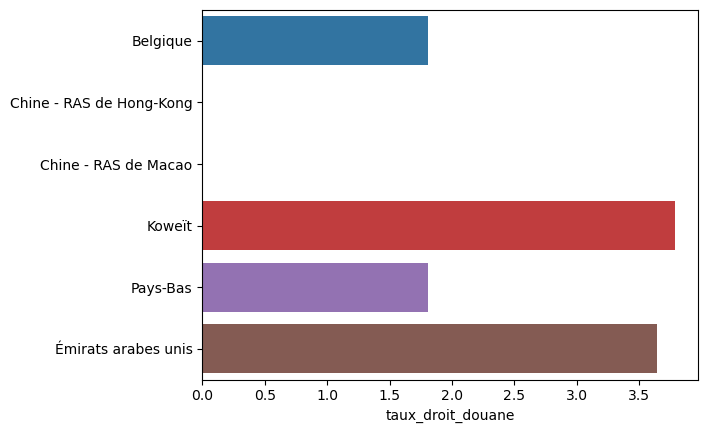

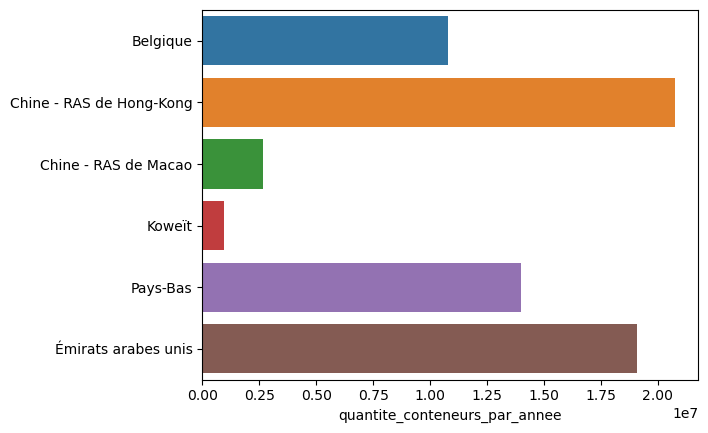

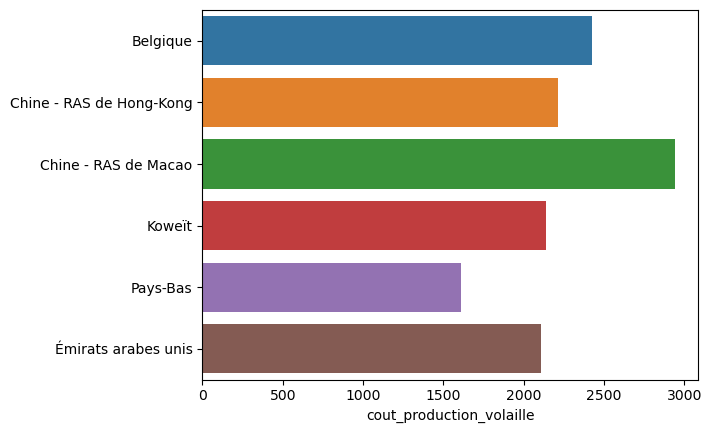

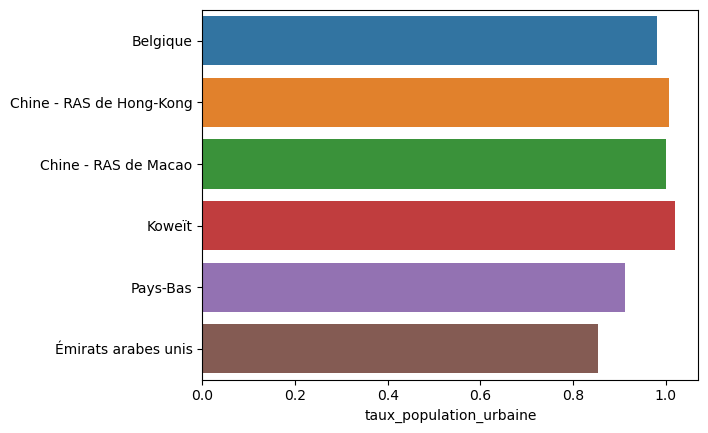

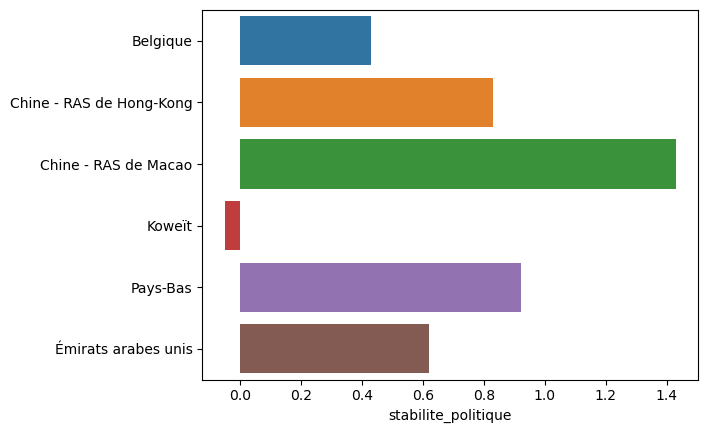

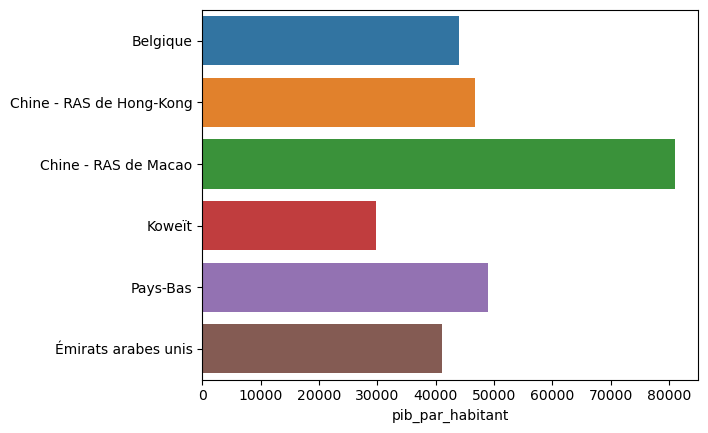

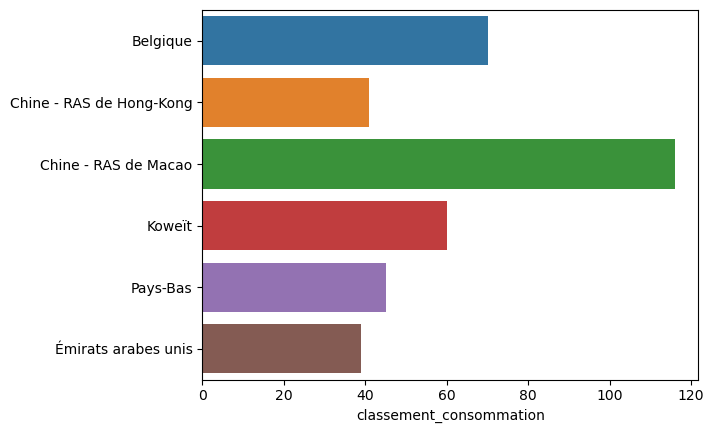

In [86]:
# Distribution des variable pour les pays sélectionnés
print("Distribution des variables")

for col in preselection:
    sns.barplot(data=preselection, x=col, y=preselection.index, orient='h')
    plt.ylabel(None)
    plt.show()

<a id="conclusion" ></a>
## Conclusion première itération<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

Ces 7 pays possèdent les caractéristiques recherchées pour implanter un nouveau marché.
On peut supposer que Macao et Honk Kong sont déjà alimentés par la Chine.

Les 4 pays européens sont particulièrement intéressant pour leur proximité géographique et leur appartenance à l'espace Schengen.
On choisira la Belgique ou les Pays Bas si on souhaite un marché important et plutôt l'Irlande ou le Luxembourg si on souhaite commencer par un plus petit marché. Sachant que ce dernier ne produit pas de poulets.

Les Émirats arabes unis pourront être intéressant de part la taille de son marché et l'accroissement de sa population.
Mais les taux de droit de douane sont plus élevés et la stabilité politique est un petit peu plus faible.

### Export Tableau

In [87]:
col_test_clusters = np.insert(kmo_col, 0, 'pays')

df_test_clusters = df[col_test_clusters]

df_test_clusters['clusters'] = clusters_kmeans
df_test_clusters['clusters'] = df_test_clusters['clusters'].astype('str')


df_test_clusters.to_csv(folder+'export_tableau.csv', index=False)

Je passe maintenant à la deuxième itération sur un autre fichier.